In [3]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import random
from sklearn.feature_selection import VarianceThreshold
from sklearn.utils import shuffle
from skmultiflow.drift_detection.adwin import ADWIN
import math

cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\matplotlib\__init__.py
normal_accessor
normal_accessor
pathobj C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data
cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data\matplotlibrc
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self .
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry
normal_accessor
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self .
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry
normal_accessor
normal_accessor
pathobj C:\Users\Terry\.matplotlib
pathobj C:\Users\Terry\.matplotlib
pathobj C:\Users\Terry\.matplotlib
cls <class 'pathlib.Path'>
os name nt
self .
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self C:\Users\Terry
normal_accessor
normal_accessor
cls <class 'pathlib.Path'>
os name nt
self .
normal_accessor
cls 

# iForest ADWIN

In [2]:
class Node:
    def __init__(self,internal=True,left=None,right=None,sAtt=None,sVal=None,size=None):
        self.internal = internal
        self.size = size
        self.left = left
        self.right = right
        self.sAtt = sAtt
        self.sVal = sVal
        return
            

In [3]:
def c(n):
#     print('3333',n)
    return 2*H(n-1)-(2*(n-1)/n)

def H(i):
    return math.log(i)+0.5772156649

In [4]:
class iTree:
    def __init__(self,X,e,l,X_cati=None):
        """
        INPUTS:
        X: input data
        e: current tree height
        l: height limit

        OUTPUT:
        """
        self.X = X
        self.l = l
        self.root = self.build(X,e,l,X_cati)
        return

    def build(self,X,e,l,X_cati=None):
#         print('e:',e,'l：',l)
        if e>=l or len(X)<=1:
#             print(e)
            return Node(internal=False,size=len(X))
        else:
            q = random.randint(0,len(X[0])-1)
            if X_cati and X_cati[q]:
                p = random.choice(list(set(X[:,q])))
                Xl = X[X[:,q]==p]
                Xr = X[X[:,q]!=p]
                return Node(internal=True,
                            left=self.build(Xl,e+1,l,X_cati),
                            right=self.build(Xr,e+1,l,X_cati),
                            sAtt=q,
                            sVal=p)
            else:
                p = random.uniform(min(X[:,q]),max(X[:,q]))
                Xl = X[X[:,q]<p]
                Xr = X[X[:,q]>=p]
                return Node(internal=True,
                            left=self.build(Xl,e+1,l,X_cati),
                            right=self.build(Xr,e+1,l,X_cati),
                            sAtt=q,
                            sVal=p)
            
    def pathLength(self,x,N=None,e=0,X_cati=None):
        """
        INPUTS:
        x: an instance
        N: a Node in the iTree
        e: current path length
        """
        if not N:
            N = self.root
        if not N.internal:
            if N.size>1:
#                 print(1)
                return e+(N.size>1)*c(N.size)
            else:
#                 print(0)
                return e
        a = N.sAtt
        if X_cati and X_cati[a]:
            if x[a] == N.sVal:
                return self.pathLength(x,N.left,e+1,X_cati)
            else:
                return self.pathLength(x,N.right,e+1,X_cati)
        else:
            if x[a] < N.sVal:
                return self.pathLength(x,N.left,e+1,X_cati)
            else:
                return self.pathLength(x,N.right,e+1,X_cati)
        
    def draw(self):
        if len(self.X[0])!=2:
            print('iTree.draw() function only support 2D data')
            return
        plt.figure()
        plt.scatter(self.X[:,0],self.X[:,1])
        limits = [[min(self.X[:,0]),max(self.X[:,0])],[min(self.X[:,1]),max(self.X[:,1])]]
        self._helper(self.root,limits)
                
    def _helper(self,node,limits):
        if not node.internal:
            return
        att = node.sAtt
        val = node.sVal
        point1 = [(1-att)*val+att*limits[1-att][0],att*val+(1-att)*limits[1-att][0]]
        point2 = [(1-att)*val+att*limits[1-att][1],att*val+(1-att)*limits[1-att][1]]
        plt.plot([point1[0],point2[0]],[point1[1],point2[1]])
        limitL = [[limits[0][0],(1-att)*val+att*limits[0][1]],[limits[1][0],(1-att)*limits[1][1]+att*val]]
        limitR = [[(1-att)*val+att*limits[0][0],limits[0][1]],[(1-att)*limits[1][0]+att*val,limits[1][1]]]
        self._helper(node.left,limitL)
        self._helper(node.right,limitR)

3

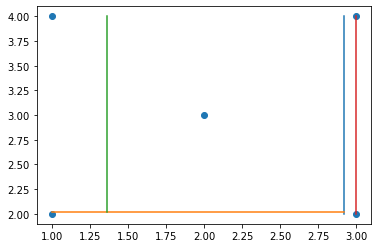

In [5]:
X = np.array([[1,2],[2,3],[3,4],[1,4],[3,2]])
tree = iTree(X,0,3)
tree.draw()
tree.pathLength([1,5])


In [6]:
import math
import random
class iForest:
    def __init__(self,X,t,phi,X_cati=None):
        """
        INPUTS:
        X: input data
        X_type: list of data type in each dimension of X
        t: number of trees
        phi: subsampling size
        
        OUTPUT:
        Forest: a set of t iTrees
        """
        self.size = t
        self.n = phi
        self.forest = []
        self._Train(X,t,phi,X_cati)
        return
        
    def _Train(self,X,t,phi,X_cati):
        # l: height limit of iTrees
        l = math.ceil(math.log2(phi))
#         l = phi/2
#         l = min(math.ceil(math.log2(phi))*2,phi/2)
        for i in range(t):
            # X_prime: subsample of X, used for training the ith iTree
            X_prime = X[np.random.choice(X.shape[0], phi, replace=False), :]
#             print(X_prime.shape)
            self.forest.append(iTree(X_prime,0,l,X_cati))
    
    def predict(self,x):
        h_sum = 0
        for i in range(self.size):
#             print(self.forest[i].pathLength(x))
            h_sum += self.forest[i].pathLength(x)
        E = h_sum/self.size
#         print('E',E)
#         print('c',c(self.n))
        return 2**(-E/c(self.n))
        

In [7]:
class ADWIN1:
    def __init__(self,delta=0.02,min_win_size=50,max_size=250):
        self.W = []
        self.delta = delta
        self.min_win_size = min_win_size
        self.max_size = max_size
        self.change = False
        
    
    def add_element(self,x):
        if len(self.W)>=self.max_size:
            del self.W[0]
        self.change = False
        self.W.append(x)
        while len(self.W)>1 and self.driftTest():
            self.change = True
            del self.W[0]
            
    def detected_change(self):
        return self.change
            
    def driftTest(self):
        for i in range(1,len(self.W)-1):
            W0 = self.W[:i]
            W1 = self.W[i:]
            n0 = len(W0)
            n1 = len(W1)
            n = len(self.W)
#             print('n0',n0,'n1',n1)
            m = 1/(1/n0+1/n1)
            delta_prime = self.delta/n
            epsilon_cut = (1/(2*m)*np.log(4/delta_prime))**(1/2)
            mu0 = np.mean(W0)
            mu1 = np.mean(W1)
            if abs(mu0-mu1)>=epsilon_cut:
                return True
        return False
            
        

In [8]:
class MADWIN:
    def __init__(self,delta=0.02,min_win_size=50,max_size=250):
        self.W = []
        self.delta = delta
        self.min_win_size = min_win_size
        self.max_size = max_size
        self.change = False
        self.min_i = 0
        self.max_i = 0
        
    
    def add_element(self,x):
        if len(self.W)>=self.max_size:
            del self.W[0]
            self.min_i += 1
        self.change = False
        self.W.append(x)
        self.max_i += 1
        while len(self.W)>1 and self.driftTest():
            self.change = True
            del self.W[-1]
            self.max_i -= 1
            
    def detected_change(self):
        ans = self.change
        self.change = False
        return ans
            
    def driftTest(self):
        for i in range(self.min_win_size,len(self.W)-self.min_win_size):
            W0 = self.W[:i]
            W1 = self.W[i:]
            n0 = len(W0)
            n1 = len(W1)
            n = len(self.W)
#             print('n0',n0,'n1',n1)
            m = 1/(1/n0+1/n1)
            delta_prime = self.delta/n
            epsilon_cut = (1/(2*m)*np.log(4/delta_prime))**(1/2)
            mu0 = np.mean(W0)
            mu1 = np.mean(W1)
            if abs(mu0-mu1)>=epsilon_cut:
                return True
        return False
            
        

In [10]:
class Detector:
    def __init__(self,t,phi,delta=0.02,min_win_size=50):
        """
        INPUTS:
        t: iforest number of trees
        phi: iforest subsampling size
        delta: adwin threshold
        min_win_size: adwin minimal window size
        """
        self.t = t
        self.phi = phi
        self.delta = delta
        self.selector = VarianceThreshold()
        self.madwin = MADWIN(delta=self.delta)
        self.feature_filter = None
        self.iforest = None
        self.prediction = []
        return
    
    def train(self,X):
        X_prime = self.selector.fit_transform(X)
        self.feature_filter = self.selector.get_support()
        self.iforest = iForest(X_prime, self.t, self.phi)
        return
    
    def predict(self,x):
        x = x.reshape((1,-1))
        xp = self.selector.transform(x)
        xp = xp.reshape((-1,))
        s = self.iforest.predict(xp)
        self.madwin.add_element(s*4)
        if self.madwin.detected_change():
            self.prediction.append(-1)
            return -1
        self.prediction.append(s)
        return s

In [11]:
class algorithm:
    def __init__(self,e,window_size,t,phi,delta=0.02,min_win_size=50,thresh=0.7):
        """
        INPUT:
        e: number of detectors
        window_size: buffer size
        t: iforest number of trees
        phi: iforest subsampling size
        delta: adwin threshold
        min_win_size: adwin minimal window size
        thresh: abnormal threshold
        """
        self.e = e
        self.window_size = window_size
        self.t = t
        self.phi = phi
        self.delta = delta
        self.thresh = thresh
        self.min_win_size = min_win_size
        self.selector = VarianceThreshold()
        self.previous_window = []
        self.current_window = []
        self.ensemble = []
        
        self.ind = 0
        return
    
    def predict(self,x):
        output = []
        var = []
        ss = [[] for _ in range(self.e)]
        if len(self.current_window)==self.window_size:
            self.previous_window = self.current_window
            self.current_window = []
            # feature selection:
            self.selector.fit(self.previous_window)
            feature_filter = self.selector.get_support()
            if self._feature_drift_detection(feature_filter) or len(self.ensemble)==0:
                # feature drift occurs OR no existing detector in ensemble
                detector = Detector(self.t,self.phi,self.delta,self.min_win_size)
#                 print('Add new detector because feature drift')
                detector.train(self.previous_window)
                if len(self.ensemble)>=self.e:
                    del self.ensemble[0]
                self.ensemble.append(detector)
                output = [-1]*len(self.previous_window)
                var = [-1]*len(self.previous_window)
            else:
                for sample in self.previous_window:
                    scores = np.zeros((len(self.ensemble),))
                    for i in range(len(self.ensemble)):
                        detector = self.ensemble[i]
                        s = -1
                        if np.array_equal(detector.feature_filter,feature_filter):
                            s = detector.predict(sample)
                            scores[i] = s
                        ss[i].append(s)
                    valid_scores = scores[scores>0]
                    if len(valid_scores)>0:
#                         print(scores)
                        score = np.max(valid_scores)
                        if score>self.thresh:
                            output.append(0)
                        else:
                            output.append(1)
                    else:
                        detector = Detector(self.t,self.phi,self.delta,self.min_win_size)
#                         print('Add new detector because concept drift')
#                         print('scores',scores)
                        detector.train(self.previous_window)
                        if len(self.ensemble)>=self.e:
                            del self.ensemble[0]
                        self.ensemble.append(detector)
                        output = [-1]*len(self.previous_window)
                        ss = [[-1]*len(self.previous_window) for _ in range(self.e)]
        self.current_window.append(x)
        return output,ss
        
    def _feature_drift_detection(self,feature_filter):
        for detector in self.ensemble:
            if np.array_equal(detector.feature_filter,feature_filter):
                return False
        return True
        

In [12]:
[[4]*5 for _ in range(6)]

[[4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4],
 [4, 4, 4, 4, 4]]

In [13]:
class iForestADWIN:
    def __init__(self,train_size,t,phi,X_cati=None,thresh=0.7,text=False,delta=0.02,min_win_size=50):
        self.i = 0
        self.train_size = train_size
        self.t = t
        self.phi = phi
        self.X_cati = X_cati
        self.forest = None
        self.delta = delta
        self.min_win_size = min_win_size
        self.adwin = ADWIN1(delta=delta,min_win_size=self.min_win_size)
        self.train_data = []
        self.score = []
        self.prediction = []
        self.train_state = True 
        self.anomaly = 0
        self.text = text
        self.thresh = thresh
        self.feature_filter = None
        return
    
    def train(self):
        self.train_data = np.array(self.train_data)
        selector = VarianceThreshold()
        self.train_data = selector.fit_transform(self.train_data)
#         print(self.train_data.shape)
        self.forest = iForest(self.train_data, self.t, self.phi, self.X_cati)
#         return
        return selector.get_support()
    
    def retrain(self):
        self.forest = None
        self.adwin = ADWIN1(delta=self.delta,min_win_size=self.min_win_size)
        self.train_data = []
        self.train_state = True
        return
    
    def add_element(self,x):
        if len(self.train_data)<self.train_size:
            self.score.append(-1)
            self.prediction.append(-1)
            self.train_data.append(x)
        elif len(self.train_data)==self.train_size and self.train_state:
            self.score.append(-1)
            self.prediction.append(-1)
            self.feature_filter = self.train()
            self.train_state = False
        else:
            x = [x[i] for i in range(len(x)) if self.feature_filter[i]]
#             print(x)
            predict = self.forest.predict(x)
#             print(predict)
            self.score.append(predict)
            self.adwin.add_element(predict*4)
            if self.adwin.detected_change():
                if self.text:
                    print('Change detected:',x,'index',self.i)
                self.prediction.append(-1)
                self.retrain()
            else:
                if predict>self.thresh:
                    self.prediction.append(0)
                    self.anomaly += 1
                    if self.text:
                        print('Anomaly detected:',x,'index',self.i)
                else:
                    self.prediction.append(1)
        self.i += 1
        return
        
        

In [140]:
dataset = ['raw_data/shuttle.txt',
           'raw_data/smtp.txt',
           'raw_data/pima.txt',
           'raw_data/satellite.txt',
           'raw_data/smtp_http.txt',
           'raw_data/shuttle.txt',
           'raw_data/shuttle.txt']

In [141]:
a = np.loadtxt(dataset[0])
stream = a[:,:-1]
label = a[:,-1]
label = 1-label
print(stream.shape)

(49097, 9)


In [41]:
def segment_generate(means,variances,length,biases,ratio,zeros):
    stream = np.zeros((len(means),length))
    indexs = np.random.choice(length,size=int(length*ratio),replace=False)
    label = np.ones((length,))
    for i in indexs:
        label[i] = 0
    for d in range(len(means)):
        if d not in zeros:
            mean = means[d]
            var = variances[d]
            bias = biases[d]
            stream[d] = np.random.normal(mean,var,length)
            for i in indexs:
                stream[d,i] = np.random.normal(mean,var+5)
    return stream.T,label

In [42]:
def evaluation(prediction,label):
    TP=0
    TN=0
    FP=0
    FN=0
    for i in range(len(label)):
        if prediction[i]!=0 and label[i]==1:
            TP += 1
        elif prediction[i]!=0 and label[i]==0:
            FP += 1
        elif prediction[i]==0 and label[i]==1:
            FN += 1
        else:
            TN += 1
    ACC = (TP+TN)/(TP+TN+FP+FN)
    Precision = TP/(TP+FP) if TP>0 else 0
    Recall = TP/(TP+FN) if TP>0 else 0
    F1 = 2*Precision*Recall/(Precision+Recall) if Precision>0 and Recall>0 else 0
    FPR = FP/(FP+TN) if FP>0 else 0
    TPR = TP/(TP+FN) if TP>0 else 0
    print('TP:',TP,'TN:',TN,'FP:',FP,'FN:',FN)
    print('ACC:',ACC,'Precision:',Precision,'Recall:',Recall,'F1:',F1)
    print('FPR:',FPR,'TPR:',TPR)
    return [TP,TN,FP,FN,ACC,Precision,Recall,F1,FPR,TPR]

(0, 10)
(3000, 10)
(3000,)


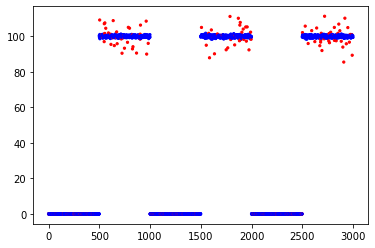

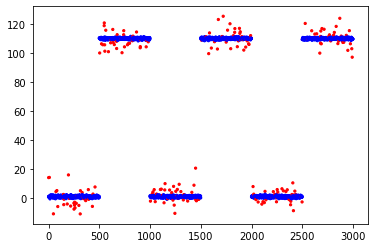

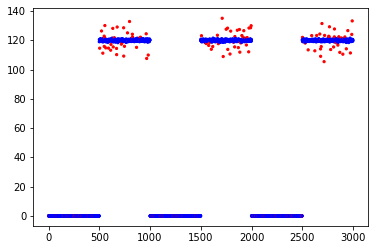

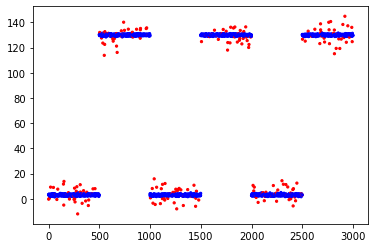

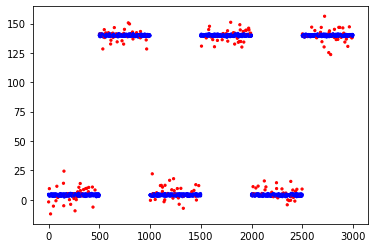

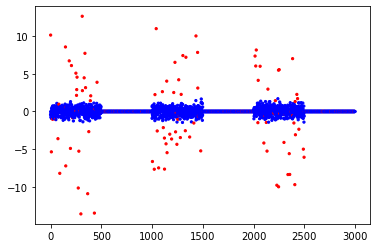

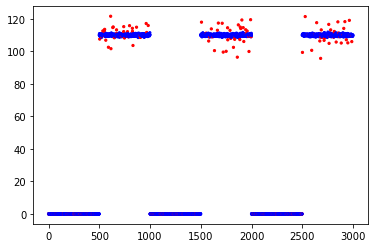

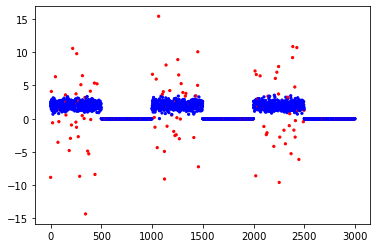

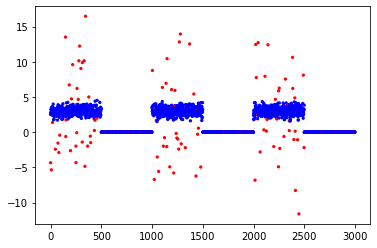

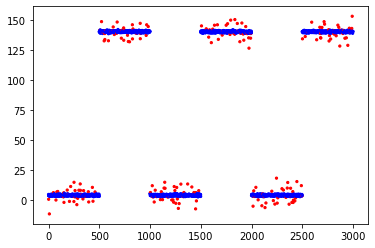

In [46]:
means = [[0,1,2,3,4,0,1,2,3,4],[100,110,120,130,140,100,110,120,130,140]]
variances = [[.5,.5,.5,.5,.5,.5,.5,.5,.5,.5],[.5,.5,.5,.5,.5,.5,.5,.5,.5,.5]]
length = 500
biases = [[20]*10,[20]*10]
zeros = [[0,2,6],[5,7,8]]
stream = np.array([]).reshape((-1,10))
label = np.array([])
print(stream.shape)
for i in range(6):
    s,l = segment_generate(means[i%2],variances[i%2],length,biases[i%2],0.07,zeros[i%2])
    stream = np.concatenate((stream,s),axis=0)
    label = np.concatenate((label,l),axis=0)
color = ['b']*len(label)
for i in range(len(label)):
    l = label[i]
    if l == 0:
        color[i] = 'r'
print(stream.shape)
print(label.shape)
for d in range(len(stream[1])):
    plt.figure()
    plt.scatter(range(length*6),stream[:,d],s=5,c=color)
    plt.show()

In [122]:
window_size_list = np.array([20,30,50,100])
t_list = np.array([20,50,75,100])
phi_list = np.array([0.1,0.25,0.5,0.75,0.9])
thresh_list = np.array([0.45,0.475,0.5,0.55,0.6,0.65])

In [142]:
# window_size_list = list(range(10,1000,50))
# t_list = list(range(10,100,20))
# phi_list = list(range(int(window_size/10),window_size,int(window_size/10)))
# thresh_list = [0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75]
import time
window_size_list = np.array([20,30,50,100])
t_list = np.array([20,50,75,100])
phi_list = np.array([0.1,0.25,0.5,0.75,0.9])
thresh_list = np.array([0.45,0.475,0.5,0.55,0.6,0.65])

# np.save("window_size_list.npy",window_size_list)
# np.save("t_list.npy",t_list)
# np.save("phi_list.npy",phi_list)
# np.save("thresh_list.npy",thresh_list)

window_size_list = [30,50]
t_list = [10,30]
phi_list = [0.5,0.9]
thresh_list = [0.5,0.6,0.7]

results = np.zeros((len(window_size_list),len(t_list),len(phi_list),len(thresh_list),2,11))
start = time.time()
for aa in range(len(window_size_list)):
    window_size = window_size_list[aa]
    for bb in range(len(t_list)):
        t = t_list[bb]
        for cc in range(len(phi_list)):
            phi = int(phi_list[cc]*window_size)
            for dd in range(len(thresh_list)):
                thresh = thresh_list[dd]
                
                print('*'*10)
                print('window_size:',window_size)
                print('t:',t)
                print('phi:',phi)
                print('thresh:',thresh)
                
                detector = algorithm(e=10,
                                     window_size=window_size,
                                     t=t,
                                     phi=phi,
                                     delta=0.02,
                                     min_win_size=5,
                                     thresh=thresh)
                prediction = []
                tic = time.time()
                for i in range(len(stream)):
                    x = stream[i]
                    output,var = detector.predict(x)
                    prediction += output
#                     e_num.append(len(detector.ensemble))
                    print(str(aa*len(t_list)*len(phi_list)*len(thresh_list)
                              +bb*len(phi_list)*len(thresh_list)
                              +cc*len(thresh_list)
                              +dd)+'/'
                            +str(len(window_size_list)
                               *len(t_list)
                               *len(phi_list)
                               *len(thresh_list))
                          +' '
                          +str(i)+'/'+str(len(stream)),end='\r')
                toc = time.time()
                print('time used:'+str(toc-tic))
                
                res = evaluation(prediction,label[:len(prediction)])
                res.append(toc-tic)
                results[aa,bb,cc,dd,0] = np.array(res)
#                 for e in range(len(detector.ensemble)):
#                     plt.figure()
#                     plt.plot(detector.ensemble[e].prediction)
#                     plt.show()
                
                detector = iForestADWIN(train_size=window_size,
                                     t=t,
                                     phi=phi,
                                     delta=0.02,
                                     min_win_size=5,
                                     thresh=thresh)
                prediction = []
                tic = time.time()
                for i in range(len(stream)):
                    x = stream[i]
                    detector.add_element(x)
                    print(str(aa*len(t_list)*len(phi_list)*len(thresh_list)
                              +bb*len(phi_list)*len(thresh_list)
                              +cc*len(thresh_list)
                              +dd)+'/'
                            +str(len(window_size_list)
                               *len(t_list)
                               *len(phi_list)
                               *len(thresh_list))
                          +' '
                          +str(i)+'/'+str(len(stream)),end='\r')
                prediction = detector.prediction
                toc = time.time()
                print('time used:'+str(toc-tic))
                
                res = evaluation(prediction,label[:len(prediction)])
                res.append(toc-tic)
                results[aa,bb,cc,dd,1] = np.array(res)
end = time.time()
# np.save("results.npy",results)
print('total time:',end-start,'s')
#                 print(results[aa,bb,cc,dd])

**********
window_size: 30
t: 10
phi: 15
thresh: 0.5
time used:180.42958736419678
TP: 38332 TN: 3424 FP: 85 FN: 7239
ACC: 0.8507742461287694 Precision: 0.9977874378530338 Recall: 0.8411489763226614 F1: 0.9127970662475593
FPR: 0.024223425477343973 TPR: 0.8411489763226614
time used:290.6249043941498
TP: 38839 TN: 3478 FP: 33 FN: 6747
ACC: 0.8619060227712487 Precision: 0.999151059888866 Recall: 0.8519940332558241 F1: 0.9197234128205736
FPR: 0.009399031614924523 TPR: 0.8519940332558241
**********
window_size: 30
t: 10
phi: 15
thresh: 0.6
time used:182.01733493804932
TP: 45548 TN: 2131 FP: 1378 FN: 23
ACC: 0.9714547677261614 Precision: 0.9706346162042364 Recall: 0.9994952930591824 F1: 0.9848535628182535
FPR: 0.3927044742091764 TPR: 0.9994952930591824
time used:290.83305835723877
TP: 45330 TN: 1825 FP: 1686 FN: 256
ACC: 0.9604456484102898 Precision: 0.9641398672792241 Recall: 0.9943842407756768 F1: 0.9790285307012808
FPR: 0.4802050697806893 TPR: 0.9943842407756768
**********
window_size: 30


KeyboardInterrupt: 

In [4]:
results = np.load('results_2.npy')
window_size_list = np.load('window_size_list_2.npy')
t_list = np.load('t_list_2.npy')
phi_list = np.load('phi_list_2.npy')
thresh_list = np.load('thresh_list_2.npy')

In [76]:

for aa in range(results.shape[0]):
    for bb in range(results.shape[1]):
        print('\\begin{table}[h]')
        print('\\centering')
        print('\\begin{tabular}{|p{1.2cm} p{1.2cm} p{1.2cm} p{1.2cm} || c|c|c|c || c|c|c|c|}')
        print('\\hline')
        print('\\multirow{2}*{Buf Size} & \\multirow{2}*{Trees} & \\multirow{2}*{samp ratio} & \\multirow{2}*{thresh} & \\multicolumn{4}{c||}{SADWIN IFA} & \\multicolumn{4}{c|}{Prop alg}\\\\')
        print('\\cline{5-12}')
        print('~ & ~ & ~ & ~ & TP & TN & FP & FN & TP & TN & FP & FN \\\\')
        print('\\hline')
        
        for cc in range(results.shape[2]):
            
                
            print('\\hline')
            for dd in range(results.shape[3]):
                print(window_size_list[aa],'&',
                      t_list[bb],'&',
                      phi_list[cc],'&',
                      thresh_list[dd],'&',
                      int(results[aa,bb,cc,dd,1,0]),'&',
                      int(results[aa,bb,cc,dd,1,1]),'&',
                      int(results[aa,bb,cc,dd,1,2]),'&',
                      int(results[aa,bb,cc,dd,1,3]),'&',
                      int(results[aa,bb,cc,dd,0,0]),'&',
                      int(results[aa,bb,cc,dd,0,1]),'&',
                      int(results[aa,bb,cc,dd,0,2]),'&',
                      int(results[aa,bb,cc,dd,0,3]),
                      '\\\\')
        print('\\hline')
        print('\\end{tabular}')
        print('\\caption{\label{tab: Comfusion Matrix }Comfusion Matrix }')
        print('\\end{table}')
        print()

\begin{table}[h]
\centering
\begin{tabular}{|p{1.2cm} p{1.2cm} p{1.2cm} p{1.2cm} || c|c|c|c || c|c|c|c|}
\hline
\multirow{2}*{Buf Size} & \multirow{2}*{Trees} & \multirow{2}*{samp ratio} & \multirow{2}*{thresh} & \multicolumn{4}{c||}{SADWIN IFA} & \multicolumn{4}{c|}{Prop alg}\\
\cline{5-12}
~ & ~ & ~ & ~ & TP & TN & FP & FN & TP & TN & FP & FN \\
\hline
\hline
20 & 20 & 0.1 & 0.45 & 2790 & 0 & 210 & 0 & 2772 & 0 & 208 & 0 \\
20 & 20 & 0.1 & 0.475 & 2790 & 0 & 210 & 0 & 2772 & 0 & 208 & 0 \\
20 & 20 & 0.1 & 0.5 & 2790 & 0 & 210 & 0 & 2772 & 0 & 208 & 0 \\
20 & 20 & 0.1 & 0.55 & 2790 & 0 & 210 & 0 & 2772 & 0 & 208 & 0 \\
20 & 20 & 0.1 & 0.6 & 2790 & 0 & 210 & 0 & 2772 & 0 & 208 & 0 \\
20 & 20 & 0.1 & 0.7 & 2790 & 0 & 210 & 0 & 2772 & 0 & 208 & 0 \\
\hline
20 & 20 & 0.25 & 0.45 & 169 & 209 & 1 & 2621 & 204 & 207 & 1 & 2568 \\
20 & 20 & 0.25 & 0.475 & 990 & 209 & 1 & 1800 & 1273 & 202 & 6 & 1499 \\
20 & 20 & 0.25 & 0.5 & 1298 & 203 & 7 & 1492 & 2412 & 199 & 9 & 360 \\
20 & 20 & 0.25 & 0.5

30 & 50 & 0.9 & 0.5 & 2713 & 194 & 16 & 77 & 2636 & 203 & 5 & 126 \\
30 & 50 & 0.9 & 0.55 & 2768 & 190 & 20 & 22 & 2756 & 201 & 7 & 6 \\
30 & 50 & 0.9 & 0.6 & 2759 & 158 & 52 & 31 & 2762 & 142 & 66 & 0 \\
30 & 50 & 0.9 & 0.7 & 2783 & 16 & 194 & 7 & 2762 & 19 & 189 & 0 \\
\hline
\end{tabular}
\caption{\label{tab: Comfusion Matrix }Comfusion Matrix }
\end{table}

\begin{table}[h]
\centering
\begin{tabular}{|p{1.2cm} p{1.2cm} p{1.2cm} p{1.2cm} || c|c|c|c || c|c|c|c|}
\hline
\multirow{2}*{Buf Size} & \multirow{2}*{Trees} & \multirow{2}*{samp ratio} & \multirow{2}*{thresh} & \multicolumn{4}{c||}{SADWIN IFA} & \multicolumn{4}{c|}{Prop alg}\\
\cline{5-12}
~ & ~ & ~ & ~ & TP & TN & FP & FN & TP & TN & FP & FN \\
\hline
\hline
30 & 75 & 0.1 & 0.45 & 2790 & 0 & 210 & 0 & 2762 & 4 & 204 & 0 \\
30 & 75 & 0.1 & 0.475 & 2790 & 0 & 210 & 0 & 2762 & 0 & 208 & 0 \\
30 & 75 & 0.1 & 0.5 & 2790 & 0 & 210 & 0 & 2762 & 0 & 208 & 0 \\
30 & 75 & 0.1 & 0.55 & 2790 & 0 & 210 & 0 & 2762 & 0 & 208 & 0 \\
30 & 75 

100 & 20 & 0.75 & 0.475 & 2748 & 166 & 44 & 42 & 2634 & 192 & 11 & 63 \\
100 & 20 & 0.75 & 0.5 & 2778 & 165 & 45 & 12 & 2680 & 192 & 11 & 17 \\
100 & 20 & 0.75 & 0.55 & 2776 & 165 & 45 & 14 & 2696 & 190 & 13 & 1 \\
100 & 20 & 0.75 & 0.6 & 2778 & 145 & 65 & 12 & 2697 & 172 & 31 & 0 \\
100 & 20 & 0.75 & 0.7 & 2781 & 36 & 174 & 9 & 2697 & 70 & 133 & 0 \\
\hline
100 & 20 & 0.9 & 0.45 & 2742 & 166 & 44 & 48 & 2623 & 192 & 11 & 74 \\
100 & 20 & 0.9 & 0.475 & 2762 & 165 & 45 & 28 & 2625 & 192 & 11 & 72 \\
100 & 20 & 0.9 & 0.5 & 2775 & 164 & 46 & 15 & 2679 & 189 & 14 & 18 \\
100 & 20 & 0.9 & 0.55 & 2779 & 164 & 46 & 11 & 2697 & 187 & 16 & 0 \\
100 & 20 & 0.9 & 0.6 & 2778 & 134 & 76 & 12 & 2697 & 167 & 36 & 0 \\
100 & 20 & 0.9 & 0.7 & 2780 & 43 & 167 & 10 & 2697 & 66 & 137 & 0 \\
\hline
\end{tabular}
\caption{\label{tab: Comfusion Matrix }Comfusion Matrix }
\end{table}

\begin{table}[h]
\centering
\begin{tabular}{|p{1.2cm} p{1.2cm} p{1.2cm} p{1.2cm} || c|c|c|c || c|c|c|c|}
\hline
\multirow{2}*{

In [13]:
for aa in range(results.shape[0]):
    for bb in range(results.shape[1]):
        print('\\begin{table}[h]')
        print('\\centering')
        print('\\begin{tabular}{| p{1cm} p{1cm} p{1cm} p{1cm} || p{1.75cm} p{1.5cm} || p{1.75cm} p{1.5cm} | p{1cm} |}')
        print('\\hline')
        print('Buf Size & Trees & samp ratio & thresh & SAd $F_1$ & SAd AUC & PCF $F_1$ & PCF AUC & Time Ratio\\\\')
        print('\\hline')
        
        for cc in range(results.shape[2]):
            print('\\hline')
            for dd in range(results.shape[3]):
                f1a = np.round(results[aa,bb,cc,dd,1,7]*100,decimals=2)
                f1b = np.round(results[aa,bb,cc,dd,0,7]*100,decimals=2)
                auca = np.round(results[aa,bb,cc,dd,1,10],decimals=2)
                aucb = np.round(results[aa,bb,cc,dd,0,10],decimals=2)
                rt = np.round(results[aa,bb,cc,dd,0,11]/results[aa,bb,cc,dd,1,11],decimals=2)
                print(window_size_list[aa],'&',
                      t_list[bb],'&',
                      phi_list[cc],'&',
                      thresh_list[dd],'&',
                      (f1a>f1b)*'\\textbf{',f1a,(f1a>f1b)*'}','\% &',
                      (auca>aucb)*'\\textbf{',auca,(auca>aucb)*'}',' &',
                      (f1a<=f1b)*'\\textbf{',f1b,(f1a<=f1b)*'}','\% &',
                      (auca<=aucb)*'\\textbf{',aucb,(auca<=aucb)*'}',' &',
                      (rt<1)*'\\textbf{',rt,(rt<1)*'}','\\\\')
        print('\\hline')
        print('\\end{tabular}')
        index = str(aa*results.shape[1]+bb)
        print('\\caption{\label{tab:Simulated data set results '+ index +' }Simulated data set results ' + index+  ' for comparison between SADWIN IFA(SAd) and PCFDAD(PCF).}')
        print('\\end{table}')
        print()

\begin{table}[h]
\centering
\begin{tabular}{| p{1cm} p{1cm} p{1cm} p{1cm} || p{1.75cm} p{1.5cm} || p{1.75cm} p{1.5cm} | p{1cm} |}
\hline
Buf Size & Trees & samp ratio & thresh & SAd $F_1$ & SAd AUC & PCF $F_1$ & PCF AUC & Time Ratio\\
\hline
\hline
20 & 20 & 0.1 & 0.45 &  96.37  \% &  0.5   & \textbf{ 96.38 } \% & \textbf{ 0.5 }  & \textbf{ 0.55 } \\
20 & 20 & 0.1 & 0.475 &  96.37  \% &  0.5   & \textbf{ 96.38 } \% & \textbf{ 0.5 }  & \textbf{ 0.55 } \\
20 & 20 & 0.1 & 0.5 &  96.37  \% &  0.5   & \textbf{ 96.38 } \% & \textbf{ 0.5 }  & \textbf{ 0.54 } \\
20 & 20 & 0.1 & 0.55 &  96.37  \% &  0.5   & \textbf{ 96.38 } \% & \textbf{ 0.5 }  & \textbf{ 0.6 } \\
20 & 20 & 0.1 & 0.6 &  96.37  \% &  0.5   & \textbf{ 96.38 } \% & \textbf{ 0.5 }  & \textbf{ 0.59 } \\
20 & 20 & 0.1 & 0.7 &  96.37  \% &  0.5   & \textbf{ 96.38 } \% & \textbf{ 0.5 }  & \textbf{ 0.58 } \\
\hline
20 & 20 & 0.25 & 0.45 &  11.42  \% &  0.72   & \textbf{ 13.71 } \% & \textbf{ 0.95 }  & \textbf{ 0.59 } \\
20 & 20 & 0.25 &

C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
C:\Users\Terry\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


 0.93   &  96.37  \% & \textbf{ 0.97 }  & \textbf{ 0.72 } \\
\hline
30 & 50 & 0.75 & 0.45 & \textbf{ 82.03 } \% &  0.93   &  70.0  \% & \textbf{ 0.97 }  & \textbf{ 0.65 } \\
30 & 50 & 0.75 & 0.475 & \textbf{ 92.22 } \% &  0.93   &  82.16  \% & \textbf{ 0.97 }  & \textbf{ 0.67 } \\
30 & 50 & 0.75 & 0.5 & \textbf{ 97.4 } \% &  0.93   &  93.91  \% & \textbf{ 0.97 }  & \textbf{ 0.65 } \\
30 & 50 & 0.75 & 0.55 &  99.03  \% &  0.93   & \textbf{ 99.69 } \% & \textbf{ 0.97 }  & \textbf{ 0.65 } \\
30 & 50 & 0.75 & 0.6 &  98.64  \% &  0.93   & \textbf{ 99.23 } \% & \textbf{ 0.97 }  & \textbf{ 0.66 } \\
30 & 50 & 0.75 & 0.7 & \textbf{ 96.5 } \% &  0.93   &  96.42  \% & \textbf{ 0.97 }  & \textbf{ 0.66 } \\
\hline
30 & 50 & 0.9 & 0.45 & \textbf{ 90.37 } \% &  0.93   &  83.64  \% & \textbf{ 0.97 }  & \textbf{ 0.67 } \\
30 & 50 & 0.9 & 0.475 & \textbf{ 95.53 } \% &  0.93   &  93.35  \% & \textbf{ 0.97 }  & \textbf{ 0.68 } \\
30 & 50 & 0.9 & 0.5 & \textbf{ 98.31 } \% &  0.93   &  97.58  \% & \textbf{

50 & 100 & 0.1 & 0.55 &  96.51  \% &  0.76   & \textbf{ 97.08 } \% & \textbf{ 0.96 }  & \textbf{ 0.55 } \\
50 & 100 & 0.1 & 0.6 & \textbf{ 96.37 } \% &  0.76   &  96.36  \% & \textbf{ 0.96 }  & \textbf{ 0.55 } \\
50 & 100 & 0.1 & 0.7 & \textbf{ 96.37 } \% &  0.74   &  96.36  \% & \textbf{ 0.96 }  & \textbf{ 0.55 } \\
\hline
50 & 100 & 0.25 & 0.45 & \textbf{ 42.04 } \% &  0.89   &  15.63  \% & \textbf{ 0.97 }  & \textbf{ 0.74 } \\
50 & 100 & 0.25 & 0.475 & \textbf{ 76.36 } \% &  0.89   &  46.04  \% & \textbf{ 0.97 }  & \textbf{ 0.69 } \\
50 & 100 & 0.25 & 0.5 & \textbf{ 91.75 } \% &  0.89   &  81.99  \% & \textbf{ 0.97 }  & \textbf{ 0.74 } \\
50 & 100 & 0.25 & 0.55 &  97.51  \% &  0.89   & \textbf{ 99.51 } \% & \textbf{ 0.97 }  & \textbf{ 0.76 } \\
50 & 100 & 0.25 & 0.6 &  97.13  \% &  0.89   & \textbf{ 98.72 } \% & \textbf{ 0.97 }  & \textbf{ 0.73 } \\
50 & 100 & 0.25 & 0.7 & \textbf{ 96.37 } \% &  0.89   &  96.36  \% & \textbf{ 0.97 }  & \textbf{ 0.76 } \\
\hline
50 & 100 & 0.5 & 0.45

In [8]:
for aa in range(results.shape[0]):
    for bb in range(results.shape[1]):
        print('\\begin{table}[h]')
        print('\\centering')
        print('\\begin{tabular}{| p{1cm} p{1cm} p{1cm} p{1cm} || p{1.75cm} p{1.5cm} || p{1.75cm} p{1.5cm} | p{1cm} |}')
        print('\\hline')
        print('Buf Size & Trees & samp ratio & thresh & SADWIN IFA $F_1$ & SADWIN IFA AUC & Prop alg $F_1$ & Prop alg AUC & Time Ratio\\\\')
        print('\\hline')
        
        for cc in range(results.shape[2]):
            print('\\hline')
            for dd in range(results.shape[3]):
                print(window_size_list[aa],'&',
                      t_list[bb],'&',
                      phi_list[cc],'&',
                      thresh_list[dd],'&',
                      np.round(results[aa,bb,cc,dd,1,7]*100,decimals=2),'\% &',
                      np.round(results[aa,bb,cc,dd,1,10],decimals=2),' &',
                      np.round(results[aa,bb,cc,dd,0,7]*100,decimals=2),'\% &',
                      np.round(results[aa,bb,cc,dd,0,10],decimals=2),' &',
                      np.round(results[aa,bb,cc,dd,0,11]/results[aa,bb,cc,dd,1,11],decimals=2),'\\\\')
        print('\\hline')
        print('\\end{tabular}')
        index = str(aa*results.shape[1]+bb)
        print('\\caption{\label{tab:Simulated data set results '+ index +' }Simulated data set results ' + index+  ' }')
        print('\\end{table}')
        print()

\begin{table}[h]
\centering
\begin{tabular}{| p{1cm} p{1cm} p{1cm} p{1cm} || p{1.75cm} p{1.5cm} || p{1.75cm} p{1.5cm} | p{1cm} |}
\hline
Buf Size & Trees & samp ratio & thresh & SADWIN IFA $F_1$ & SADWIN IFA AUC & Prop alg $F_1$ & Prop alg AUC & Time Ratio\\
\hline
\hline
20 & 20 & 0.1 & 0.45 & 96.37 \% & 0.5  & 96.38 \% & 0.5  & 0.55 \\
20 & 20 & 0.1 & 0.475 & 96.37 \% & 0.5  & 96.38 \% & 0.5  & 0.55 \\
20 & 20 & 0.1 & 0.5 & 96.37 \% & 0.5  & 96.38 \% & 0.5  & 0.54 \\
20 & 20 & 0.1 & 0.55 & 96.37 \% & 0.5  & 96.38 \% & 0.5  & 0.6 \\
20 & 20 & 0.1 & 0.6 & 96.37 \% & 0.5  & 96.38 \% & 0.5  & 0.59 \\
20 & 20 & 0.1 & 0.7 & 96.37 \% & 0.5  & 96.38 \% & 0.5  & 0.58 \\
\hline
20 & 20 & 0.25 & 0.45 & 11.42 \% & 0.72  & 13.71 \% & 0.95  & 0.59 \\
20 & 20 & 0.25 & 0.475 & 52.37 \% & 0.82  & 62.85 \% & 0.89  & 0.59 \\
20 & 20 & 0.25 & 0.5 & 63.39 \% & 0.79  & 92.89 \% & 0.96  & 0.61 \\
20 & 20 & 0.25 & 0.55 & 96.74 \% & 0.82  & 96.63 \% & 0.88  & 0.58 \\
20 & 20 & 0.25 & 0.6 & 96.42 \% & 0.74  &

30 & 100 & 0.5 & 0.6 & 97.59 \% & 0.93  & 98.93 \% & 0.97  & 0.67 \\
30 & 100 & 0.5 & 0.7 & 96.37 \% & 0.93  & 96.39 \% & 0.97  & 0.65 \\
\hline
30 & 100 & 0.75 & 0.45 & 78.52 \% & 0.93  & 70.03 \% & 0.97  & 0.63 \\
30 & 100 & 0.75 & 0.475 & 94.43 \% & 0.93  & 91.08 \% & 0.97  & 0.63 \\
30 & 100 & 0.75 & 0.5 & 97.74 \% & 0.93  & 97.27 \% & 0.97  & 0.63 \\
30 & 100 & 0.75 & 0.55 & 99.07 \% & 0.93  & 99.73 \% & 0.97  & 0.63 \\
30 & 100 & 0.75 & 0.6 & 98.61 \% & 0.93  & 99.1 \% & 0.97  & 0.63 \\
30 & 100 & 0.75 & 0.7 & 96.32 \% & 0.93  & 96.44 \% & 0.97  & 0.64 \\
\hline
30 & 100 & 0.9 & 0.45 & 87.35 \% & 0.93  & 84.85 \% & 0.97  & 0.63 \\
30 & 100 & 0.9 & 0.475 & 95.5 \% & 0.93  & 92.44 \% & 0.97  & 0.63 \\
30 & 100 & 0.9 & 0.5 & 98.79 \% & 0.93  & 97.88 \% & 0.97  & 0.65 \\
30 & 100 & 0.9 & 0.55 & 99.21 \% & 0.93  & 99.86 \% & 0.97  & 0.63 \\
30 & 100 & 0.9 & 0.6 & 98.66 \% & 0.93  & 99.16 \% & 0.97  & 0.63 \\
30 & 100 & 0.9 & 0.7 & 96.41 \% & 0.93  & 96.59 \% & 0.97  & 0.63 \\
\hline
\

100 & 100 & 0.75 & 0.475 & 98.77 \% & 0.82  & 99.14 \% & 0.93  & 0.73 \\
100 & 100 & 0.75 & 0.5 & 98.91 \% & 0.82  & 99.69 \% & 0.93  & 0.73 \\
100 & 100 & 0.75 & 0.55 & 98.9 \% & 0.82  & 99.8 \% & 0.93  & 0.73 \\
100 & 100 & 0.75 & 0.6 & 98.63 \% & 0.81  & 99.63 \% & 0.93  & 0.72 \\
100 & 100 & 0.75 & 0.7 & 96.73 \% & 0.82  & 97.36 \% & 0.93  & 0.73 \\
\hline
100 & 100 & 0.9 & 0.45 & 98.73 \% & 0.82  & 98.39 \% & 0.93  & 0.71 \\
100 & 100 & 0.9 & 0.475 & 98.98 \% & 0.82  & 99.48 \% & 0.93  & 0.73 \\
100 & 100 & 0.9 & 0.5 & 99.04 \% & 0.82  & 99.76 \% & 0.93  & 0.72 \\
100 & 100 & 0.9 & 0.55 & 98.9 \% & 0.82  & 99.74 \% & 0.93  & 0.73 \\
100 & 100 & 0.9 & 0.6 & 98.69 \% & 0.82  & 99.43 \% & 0.93  & 0.72 \\
100 & 100 & 0.9 & 0.7 & 96.82 \% & 0.82  & 97.24 \% & 0.93  & 0.72 \\
\hline
\end{tabular}
\caption{\label{tab:Simulated data set results 15 }Simulated data set results 15 }
\end{table}



In [23]:
table = np.zeros((results.shape[0]*results.shape[1]*results.shape[2]*results.shape[3],
                  7))
print(table.shape)
for aa in range(results.shape[0]):
    for bb in range(results.shape[1]):
        for cc in range(results.shape[2]):
            for dd in range(results.shape[3]):
                index = aa*results.shape[1]*results.shape[2]*results.shape[3]+bb*results.shape[2]*results.shape[3]+cc*results.shape[3]+dd
                table[index,0] = window_size_list[aa]
                table[index,1] = t_list[bb]
                table[index,2] = phi_list[cc]
                table[index,3] = thresh_list[dd]
                table[index,4] = results[aa,bb,cc,dd,0,7]
                table[index,5] = results[aa,bb,cc,dd,1,7]
                table[index,6] = results[aa,bb,cc,dd,0,10]/results[aa,bb,cc,dd,1,10]
print(table[0])
table = np.round(table,decimals=4)

(480, 7)
[20.         20.          0.1         0.45        0.96383866  0.96373057
  0.55996888]


In [25]:
np.savetxt('table.csv',table,delimiter=',')

[ 20  30  50 100]


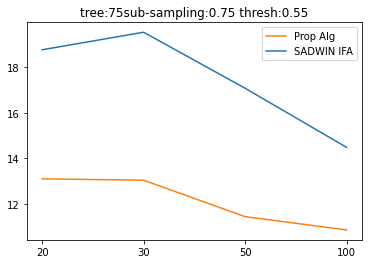

In [5]:
print(window_size_list)
plt.figure()
result1 = results[:,2,3,3,0,11]
result2 = results[:,2,3,3,1,11]
plt.plot(result1,color='tab:orange')
plt.plot(result2,color='tab:blue')
plt.title('tree:'+str(t_list[2])+
          'sub-sampling:'+str(phi_list[3])+
          ' thresh:'+str(thresh_list[3]))

plt.legend(['Prop Alg','SADWIN IFA'])
plt.xticks(list(range(len(result1))),window_size_list)
plt.show()

[ 20  30  50 100]


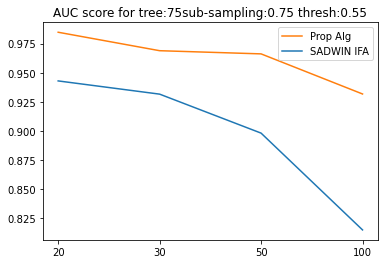

In [6]:
print(window_size_list)
plt.figure()
result1 = results[:,2,3,3,0,10]
result2 = results[:,2,3,3,1,10]
plt.plot(result1,color='tab:orange')
plt.plot(result2,color='tab:blue')
plt.title('AUC score for tree:'+str(t_list[2])+
          'sub-sampling:'+str(phi_list[3])+
          ' thresh:'+str(thresh_list[3]))

plt.legend(['Prop Alg','SADWIN IFA'])
plt.xticks(list(range(len(result1))),window_size_list)
plt.show()

[ 20  30  50 100]


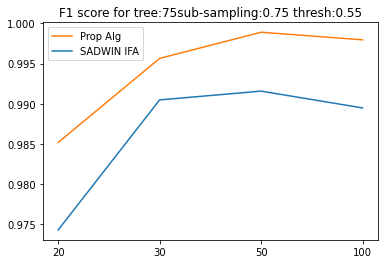

In [7]:
print(window_size_list)
plt.figure()
result1 = results[:,2,3,3,0,7]
result2 = results[:,2,3,3,1,7]
plt.plot(result1,color='tab:orange')
plt.plot(result2,color='tab:blue')
plt.title('F1 score for tree:'+str(t_list[2])+
          'sub-sampling:'+str(phi_list[3])+
          ' thresh:'+str(thresh_list[3]))

plt.legend(['Prop Alg','SADWIN IFA'])
plt.xticks(list(range(len(result1))),window_size_list)
plt.show()

# Number of trees

[0.45  0.475 0.5   0.55  0.6   0.7  ]


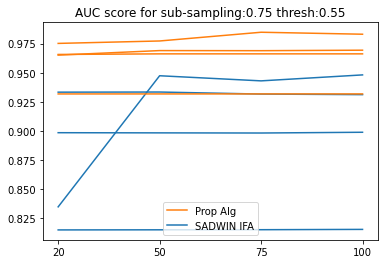

In [107]:
print(thresh_list)
plt.figure()
for aa in range(results.shape[0]):
    result1 = results[aa,:,3,3,0,10]
    result2 = results[aa,:,3,3,1,10]
    plt.plot(result1,color='tab:orange')
    plt.plot(result2,color='tab:blue')
    plt.title('AUC score for sub-sampling:'+str(phi_list[3])+
              ' thresh:'+str(thresh_list[3]))

plt.legend(['Prop Alg','SADWIN IFA'])
plt.xticks(list(range(len(result1))),t_list)
plt.show()

[0.45  0.475 0.5   0.55  0.6   0.7  ]


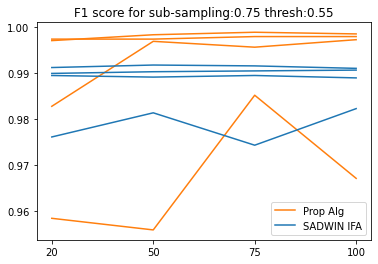

In [105]:
print(thresh_list)
plt.figure()
for aa in range(results.shape[0]):
    result1 = results[aa,:,3,3,0,7]
    result2 = results[aa,:,3,3,1,7]
    plt.plot(result1,color='tab:orange')
    plt.plot(result2,color='tab:blue')
    plt.title('F1 score for sub-sampling:'+str(phi_list[3])+
              ' thresh:'+str(thresh_list[3]))

plt.legend(['Prop Alg','SADWIN IFA'])
plt.xticks(list(range(len(result1))),t_list)
plt.show()

# subsampling selection

In [ ]:
for aa in range(results.shape[0]):
    fig, axs = plt.subplots(2, 1)

[0.45  0.475 0.5   0.55  0.6   0.7  ]


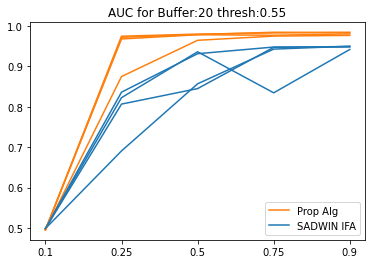

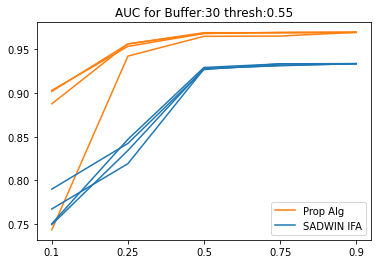

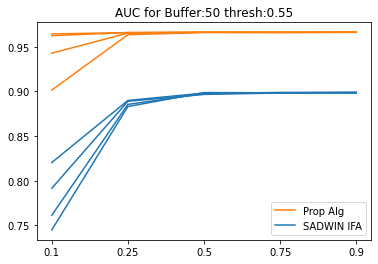

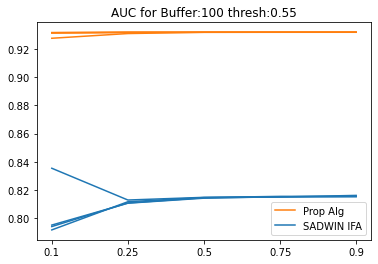

In [104]:
print(thresh_list)
for aa in range(results.shape[0]):
    plt.figure()
    for bb in range(results.shape[1]):
        result1 = results[aa,bb,:,3,0,10]
        result2 = results[aa,bb,:,3,1,10]
        plt.plot(result1,color='tab:orange')
        plt.plot(result2,color='tab:blue')
    plt.title('AUC for Buffer:'+str(window_size_list[aa])+
              ' thresh:'+str(thresh_list[3]))

    plt.legend(['Prop Alg','SADWIN IFA'])
    plt.xticks(list(range(len(result1))),phi_list)
    plt.show()

[0.45  0.475 0.5   0.55  0.6   0.7  ]


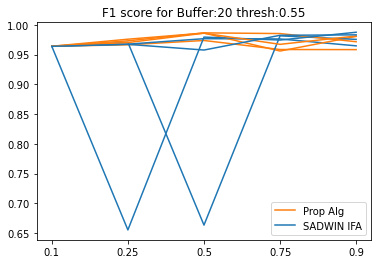

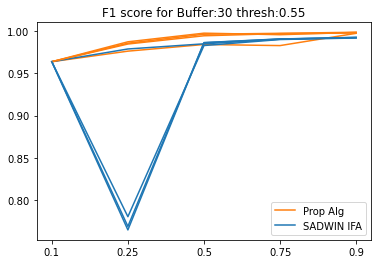

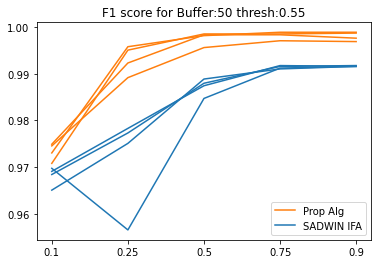

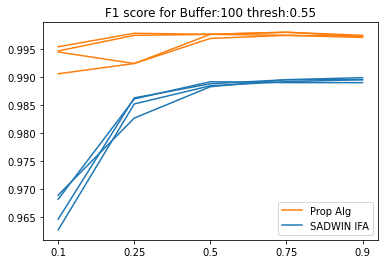

In [94]:
print(thresh_list)
for aa in range(results.shape[0]):
    plt.figure()
    for bb in range(results.shape[1]):
        result1 = results[aa,bb,:,3,0,7]
        result2 = results[aa,bb,:,3,1,7]
        plt.plot(result1,color='tab:orange')
        plt.plot(result2,color='tab:blue')
    plt.title('F1 score for Buffer:'+str(window_size_list[aa])+
              ' thresh:'+str(thresh_list[bb]))

    plt.legend(['Prop Alg','SADWIN IFA'])
    plt.xticks(list(range(len(result1))),phi_list)
    plt.show()

[0.45  0.475 0.5   0.55  0.6   0.7  ]


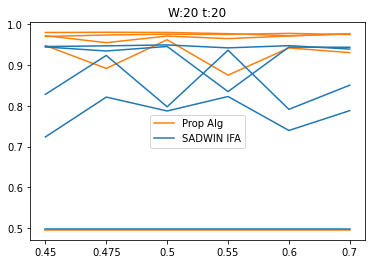

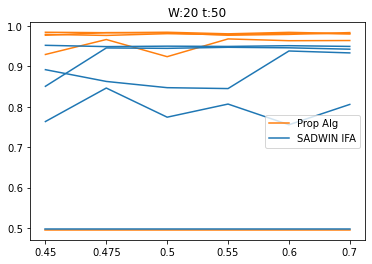

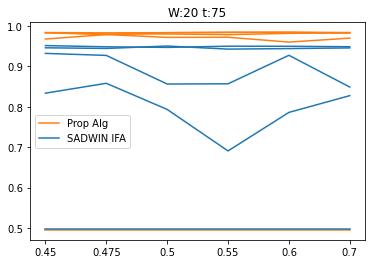

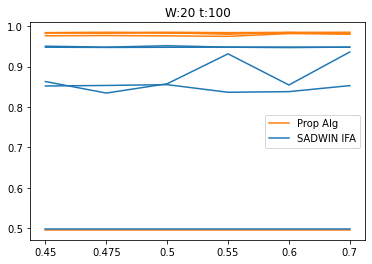

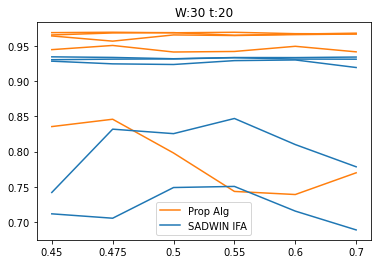

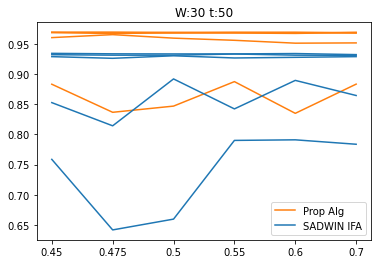

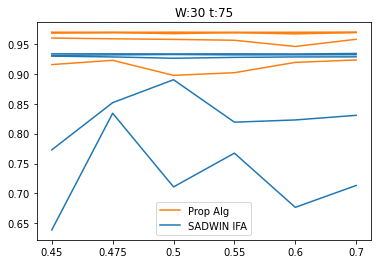

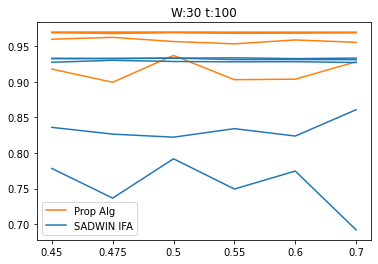

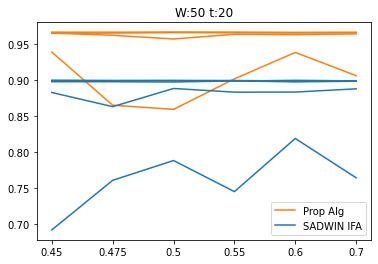

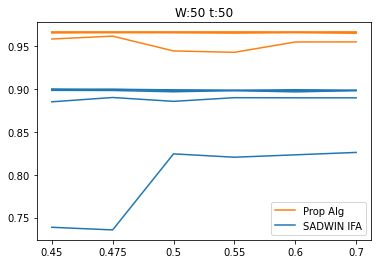

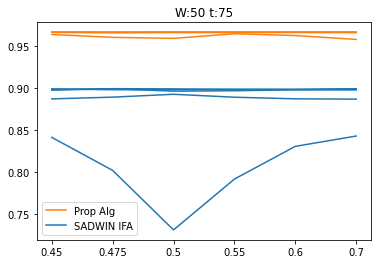

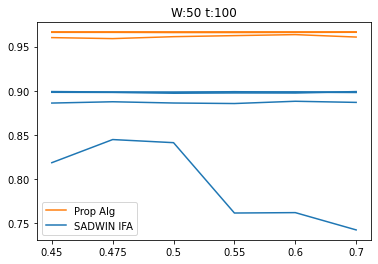

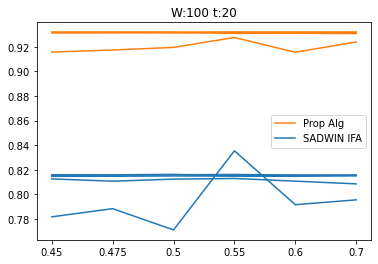

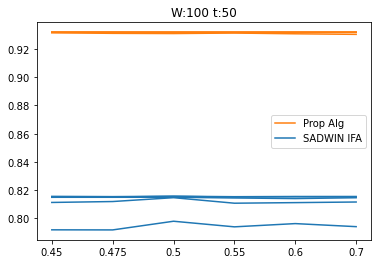

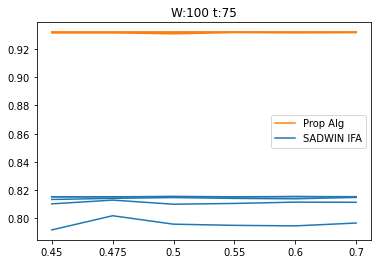

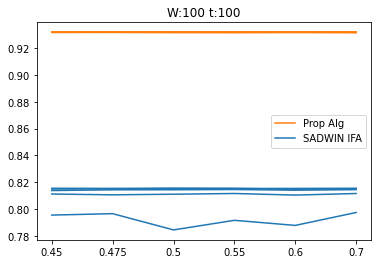

In [77]:
print(thresh_list)
for aa in range(results.shape[0]):
    for bb in range(results.shape[1]):
        plt.figure()
        for cc in range(results.shape[2]):
            result1 = results[aa,bb,cc,:,0,10]
            result2 = results[aa,bb,cc,:,1,10]
            plt.plot(result1,color='tab:orange')
            plt.plot(result2,color='tab:blue')
        plt.title('W:'+str(window_size_list[aa])+
                  ' t:'+str(t_list[bb]))

        plt.legend(['Prop Alg','SADWIN IFA'])
        plt.xticks(list(range(len(result1))),thresh_list)
        plt.show()

Threshold F1 score plots

[0.45  0.475 0.5   0.55  0.6   0.7  ]


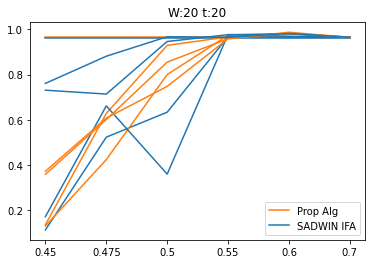

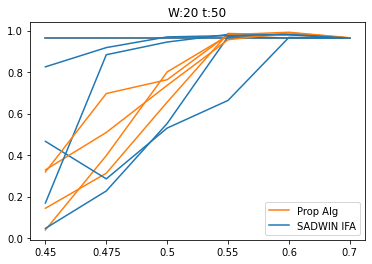

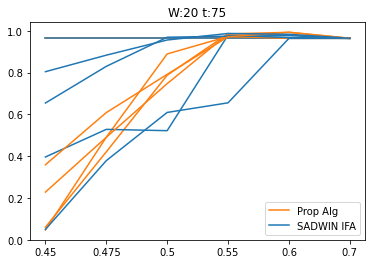

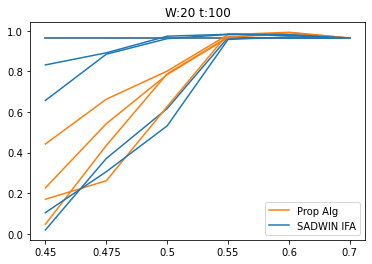

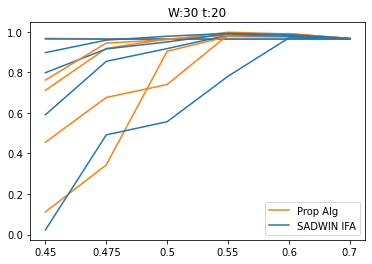

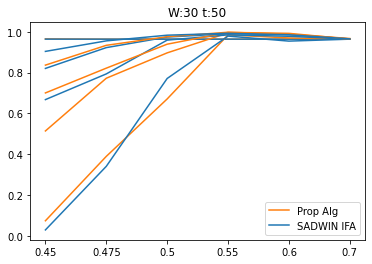

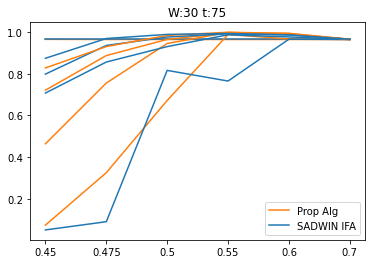

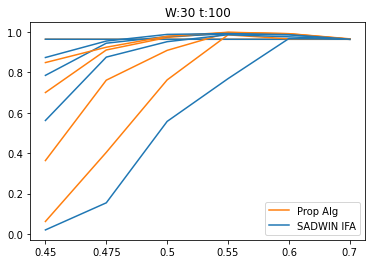

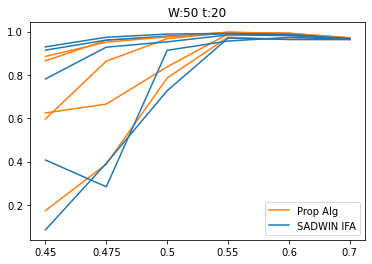

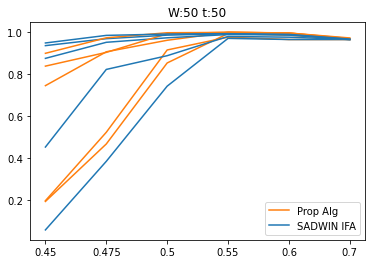

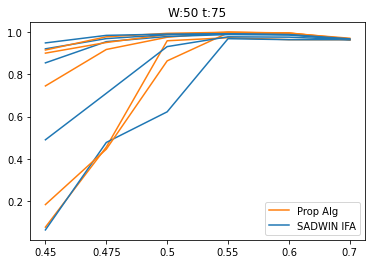

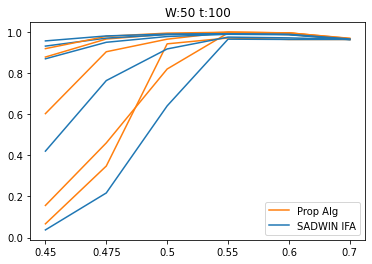

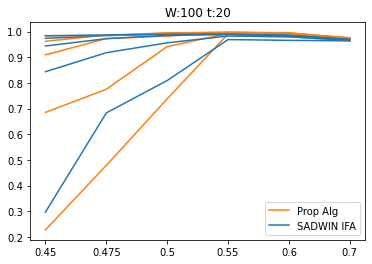

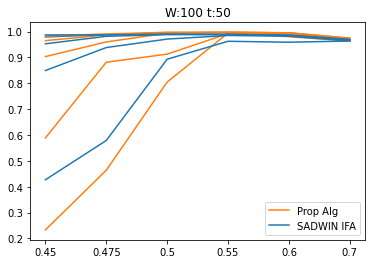

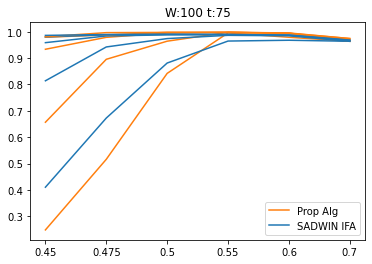

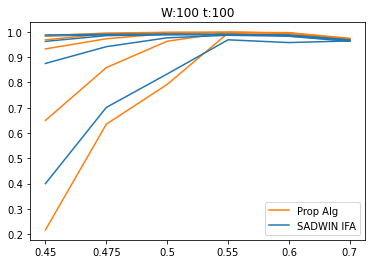

In [61]:
print(thresh_list)
for aa in range(results.shape[0]):
    for bb in range(results.shape[1]):
        plt.figure()
        for cc in range(results.shape[2]):
            result1 = results[aa,bb,cc,:,0,7]
            result2 = results[aa,bb,cc,:,1,7]
            plt.plot(result1,color='tab:orange')
            plt.plot(result2,color='tab:blue')
        plt.title('W:'+str(window_size_list[aa])+
                  ' t:'+str(t_list[bb]))

        plt.legend(['Prop Alg','SADWIN IFA'])
        plt.xticks(list(range(len(result1))),thresh_list)
        plt.show()

[0.45  0.475 0.5   0.55  0.6   0.7  ]


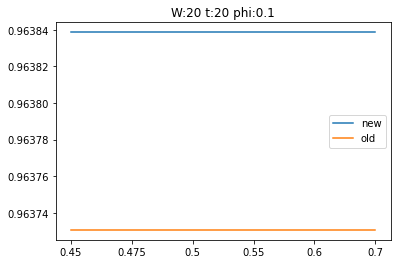

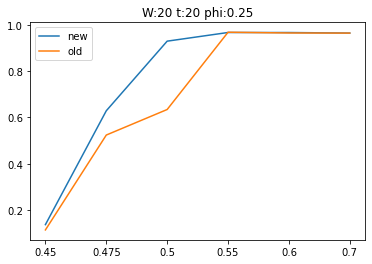

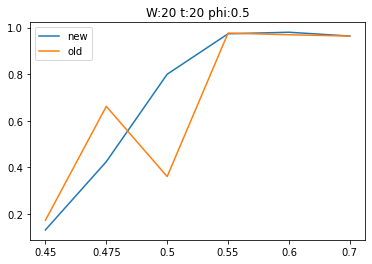

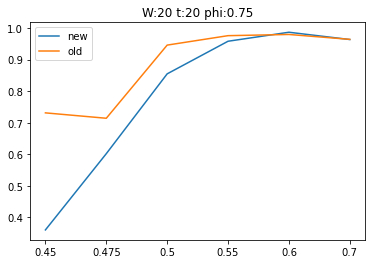

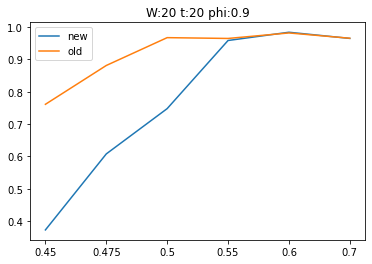

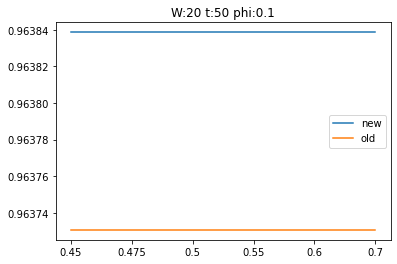

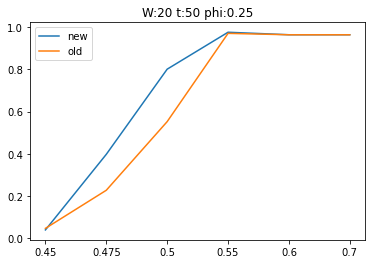

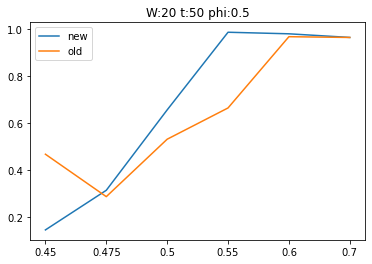

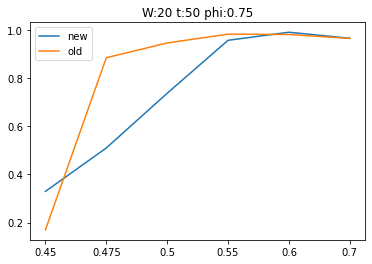

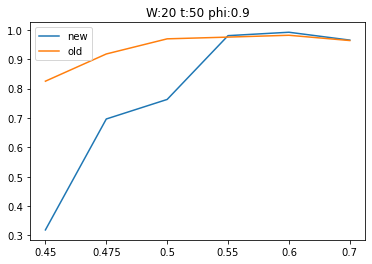

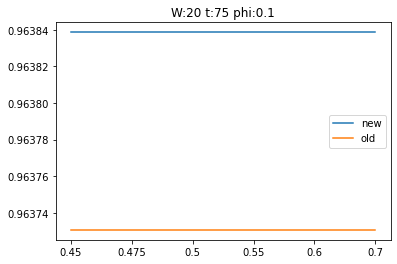

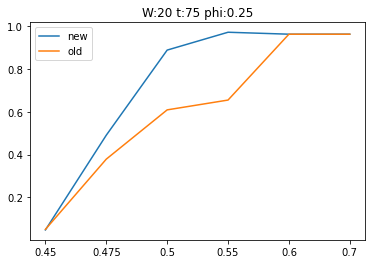

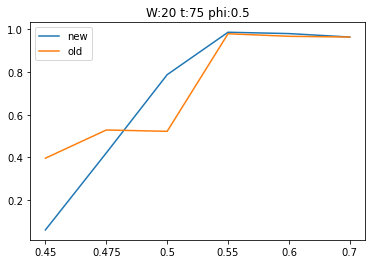

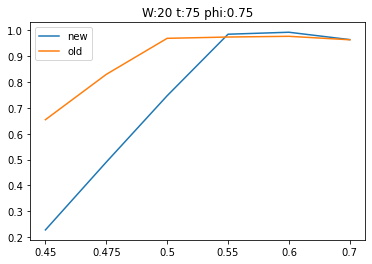

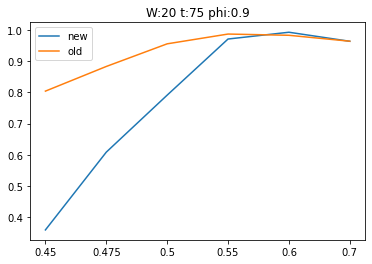

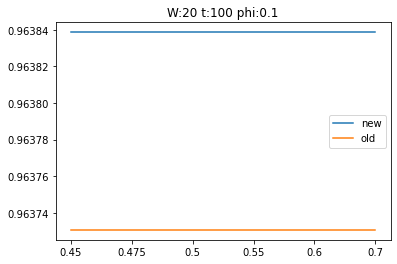

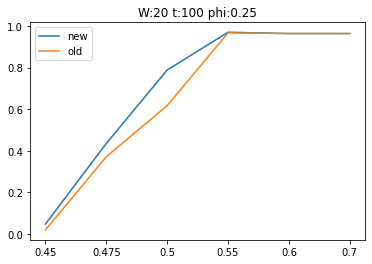

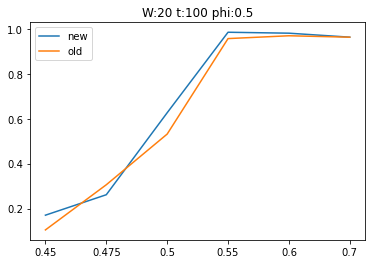

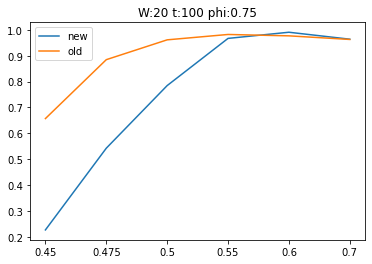

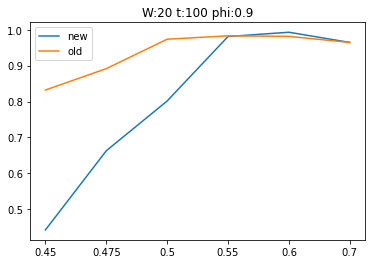

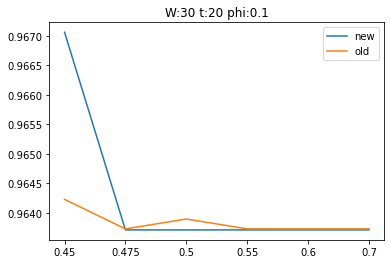

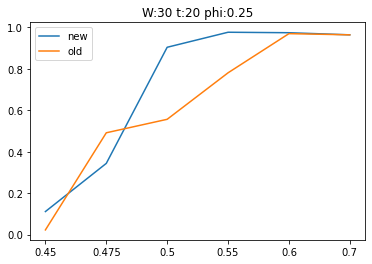

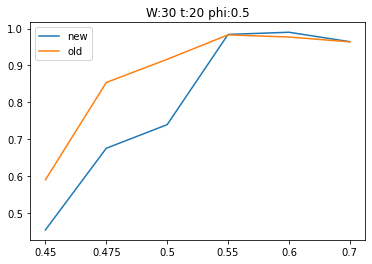

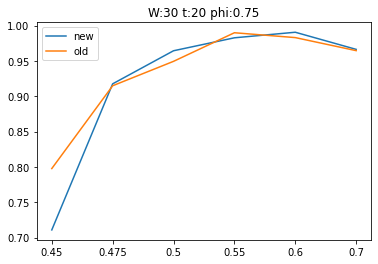

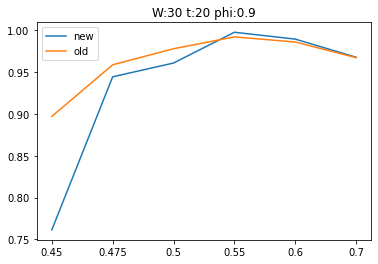

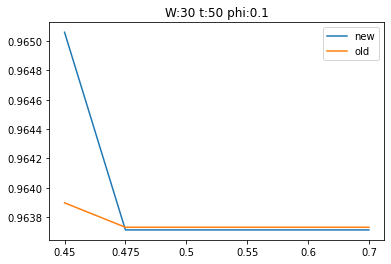

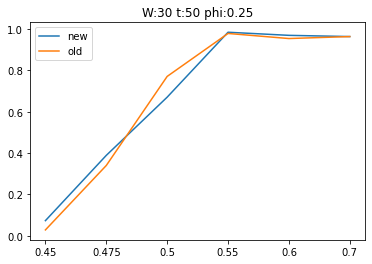

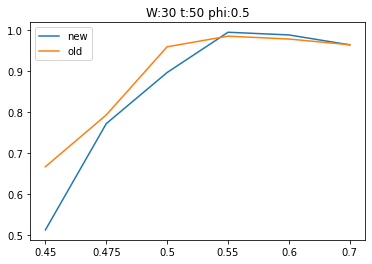

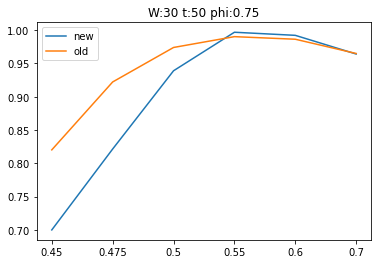

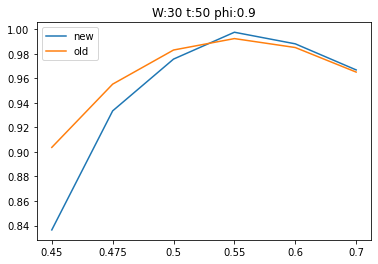

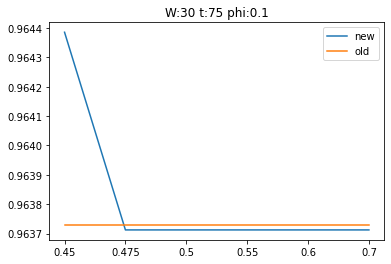

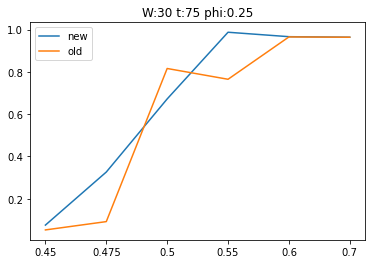

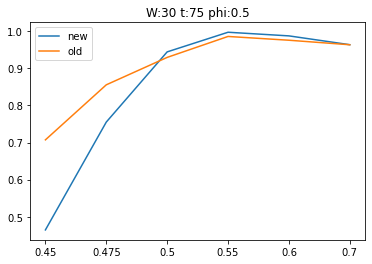

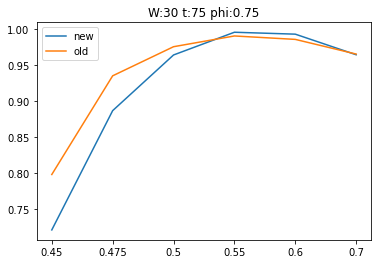

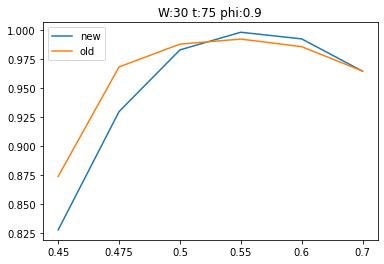

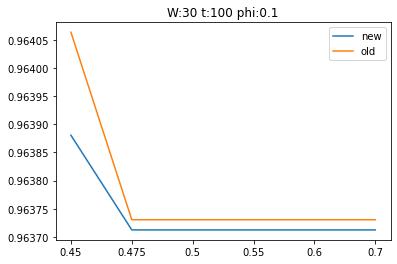

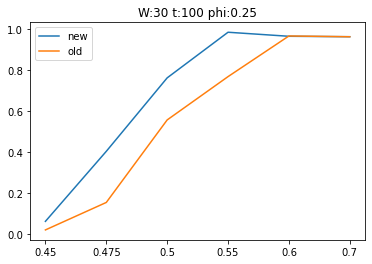

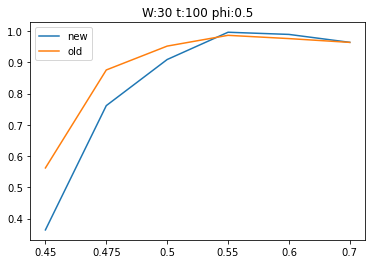

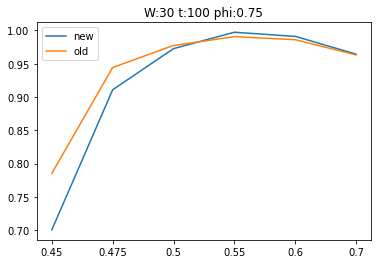

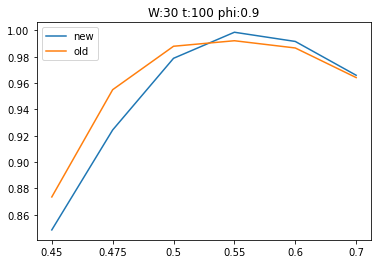

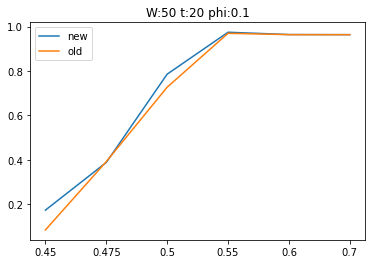

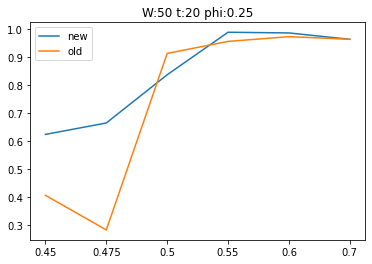

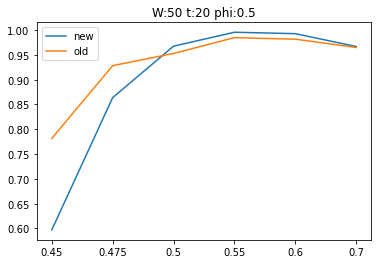

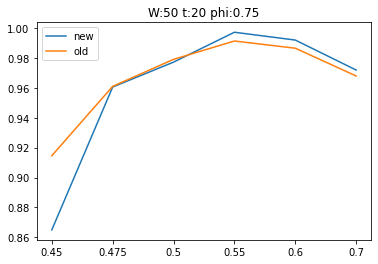

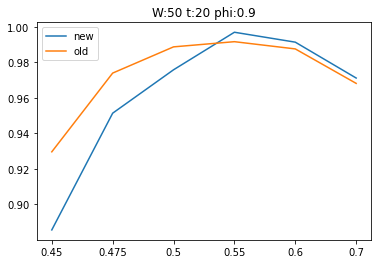

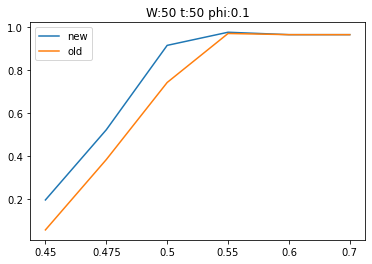

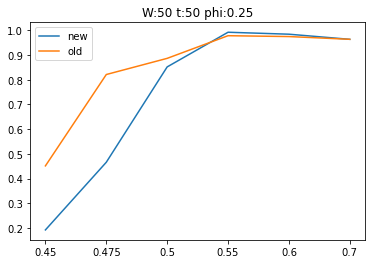

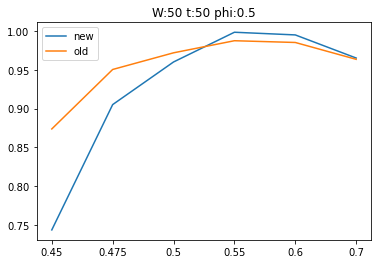

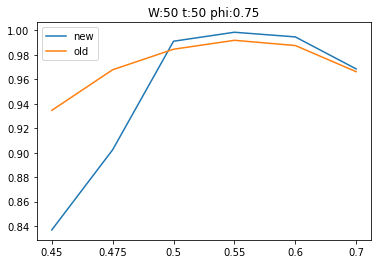

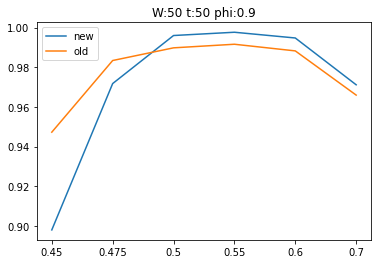

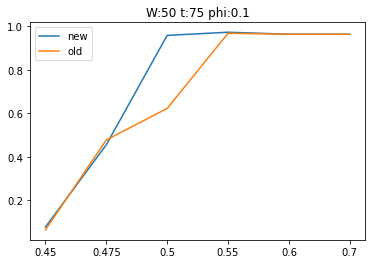

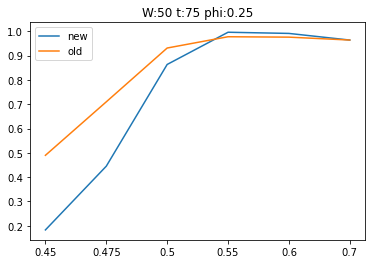

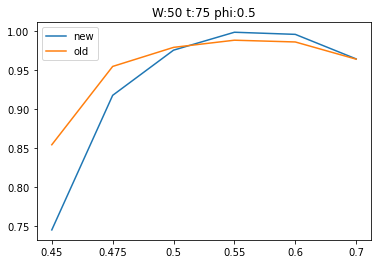

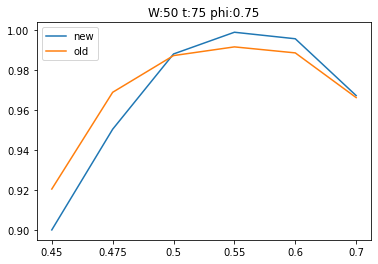

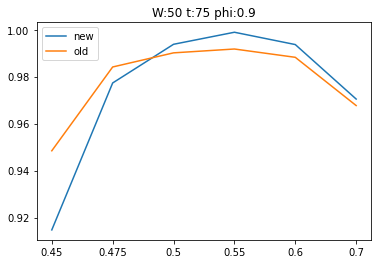

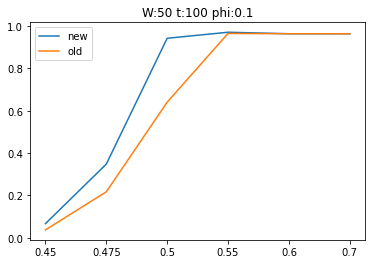

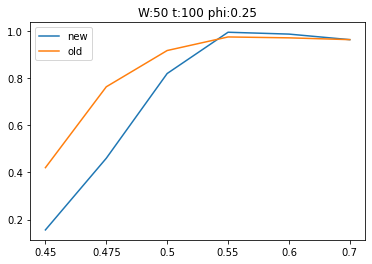

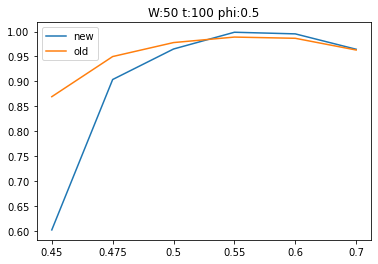

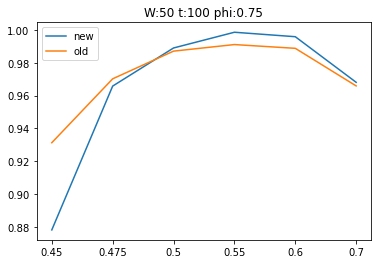

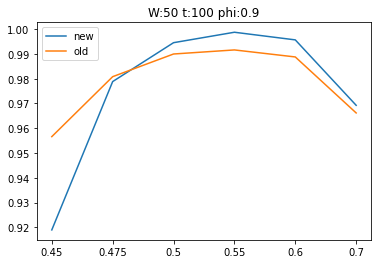

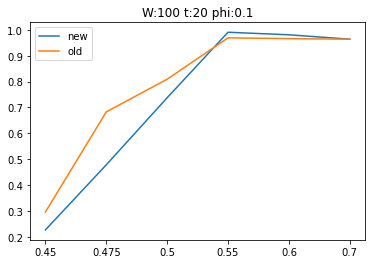

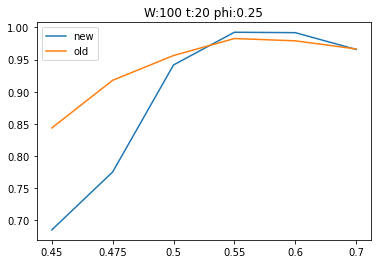

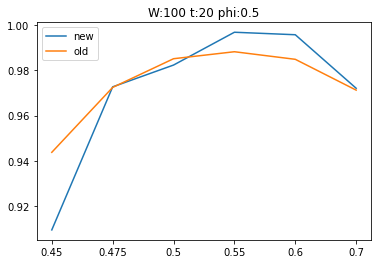

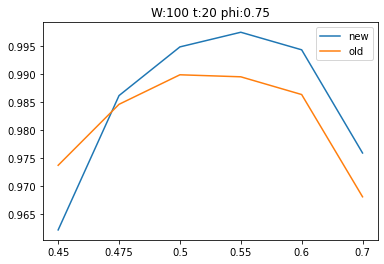

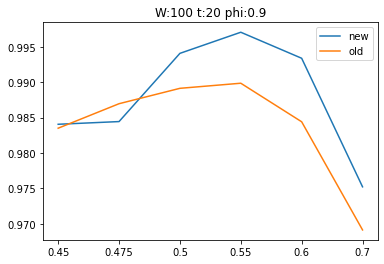

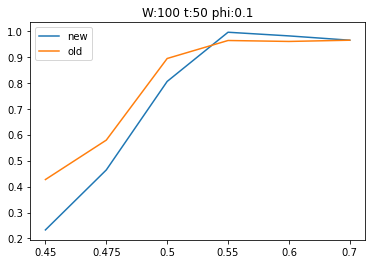

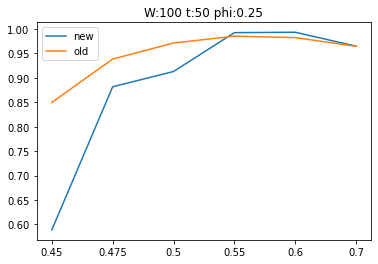

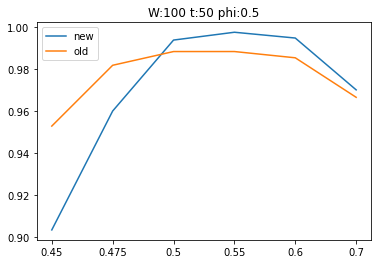

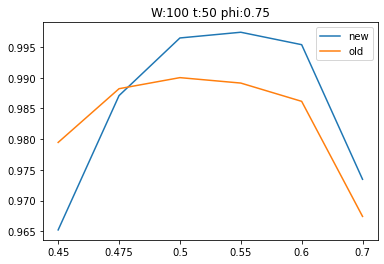

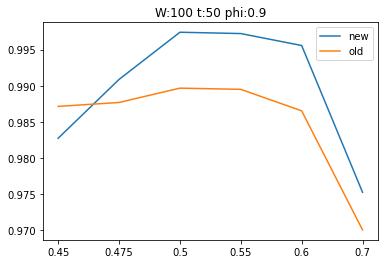

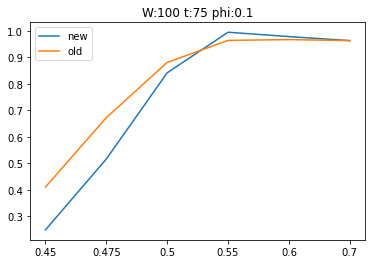

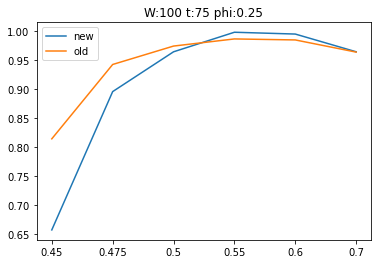

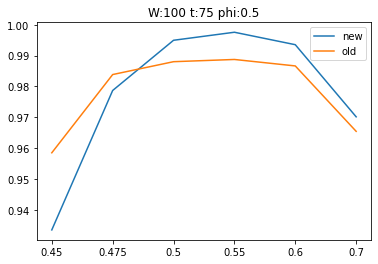

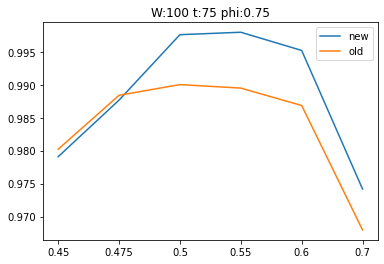

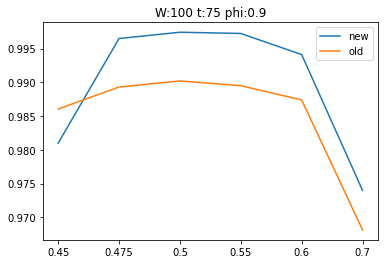

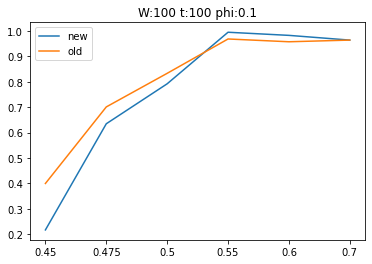

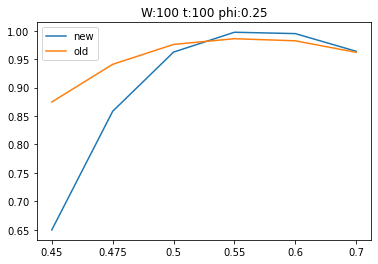

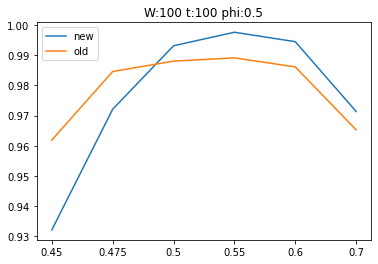

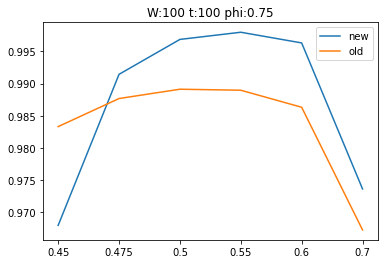

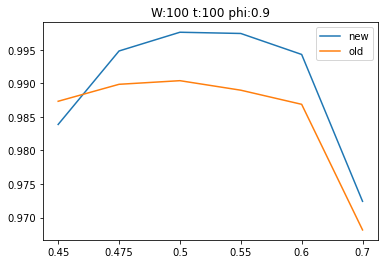

In [54]:

print(thresh_list)
for aa in range(results.shape[0]):
    for bb in range(results.shape[1]):
        for cc in range(results.shape[2]):
            result1 = results[aa,bb,cc,:,0,7]
            result2 = results[aa,bb,cc,:,1,7]
            plt.plot(result1)
            plt.plot(result2)
            plt.title('W:'+str(window_size_list[aa])+
                      ' t:'+str(t_list[bb])+
                      ' phi:'+str(phi_list[cc]))
            
            plt.legend(['new','old'])
            plt.xticks(list(range(len(result1))),thresh_list)
            plt.show()

[0.1  0.25 0.5  0.75 0.9 ]


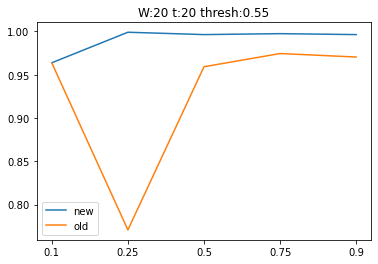

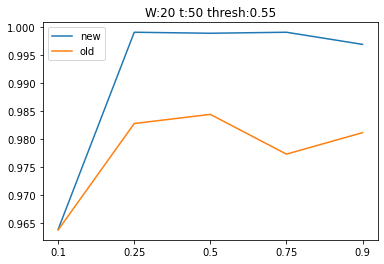

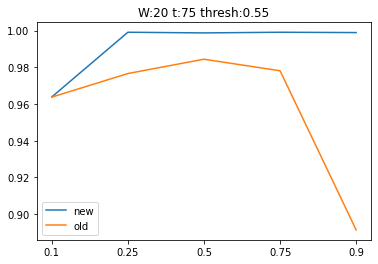

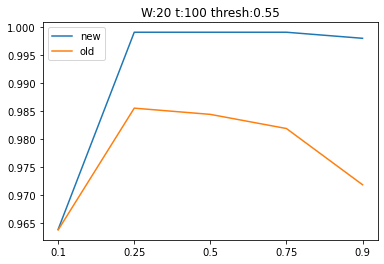

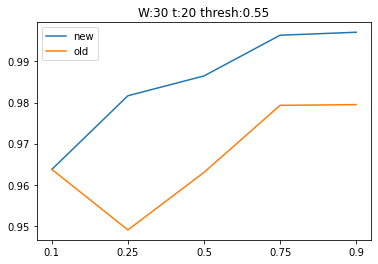

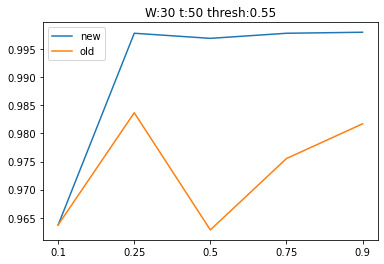

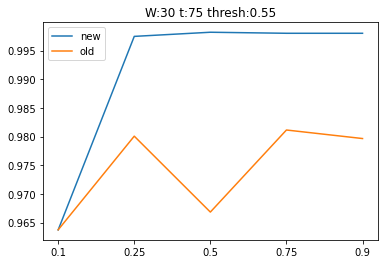

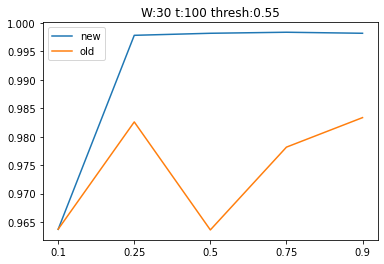

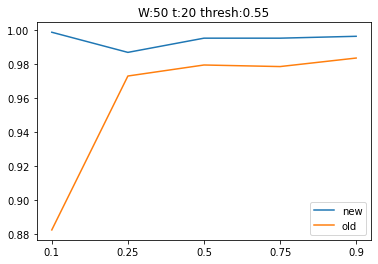

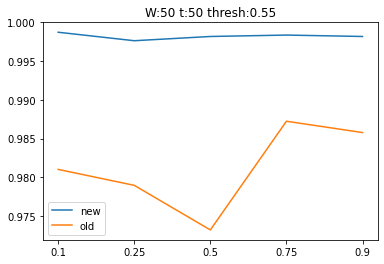

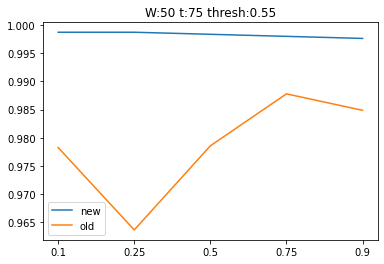

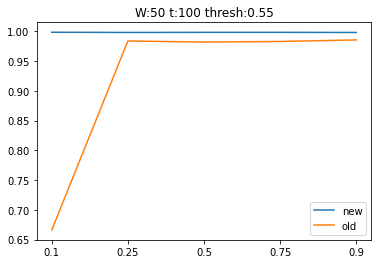

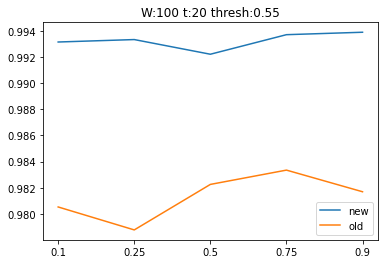

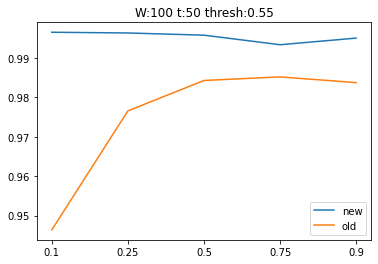

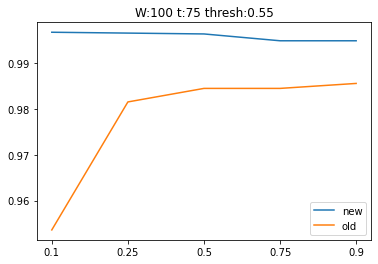

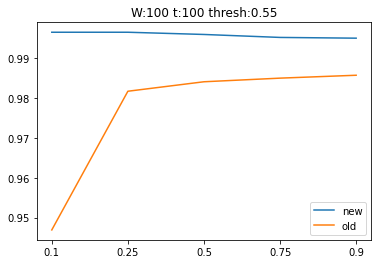

In [136]:
print(phi_list)
for aa in range(results.shape[0]):
    for bb in range(results.shape[1]):
            result1 = results[aa,bb,:,3,0,7]
            result2 = results[aa,bb,:,3,1,7]
            plt.plot(result1)
            plt.plot(result2)
            plt.title('W:'+str(window_size_list[aa])+
                      ' t:'+str(t_list[bb])+
                      ' thresh:'+str(thresh_list[3]))
            
            plt.legend(['new','old'])
            plt.xticks(list(range(len(result1))),phi_list)
            plt.show()

[ 20  50  75 100]


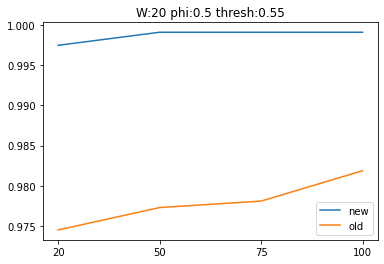

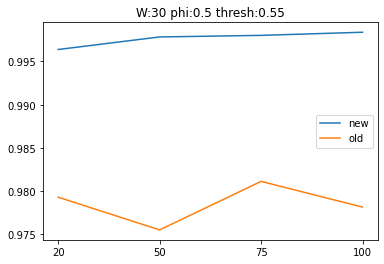

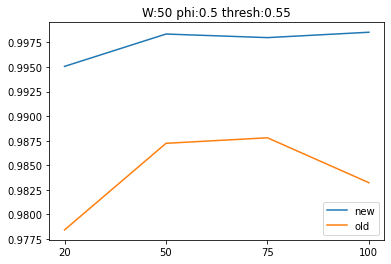

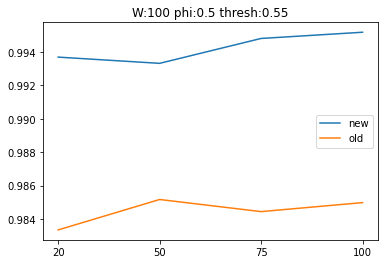

In [137]:
print(t_list)
for aa in range(results.shape[0]):
    result1 = results[aa,:,3,3,0,7]
    result2 = results[aa,:,3,3,1,7]
    plt.plot(result1)
    plt.plot(result2)
    plt.title('W:'+str(window_size_list[aa])+
              ' phi:'+str(phi_list[2])+
              ' thresh:'+str(thresh_list[3]))

    plt.legend(['new','old'])
    plt.xticks(list(range(len(result1))),t_list)
    plt.show()

[ 20  50  75 100]


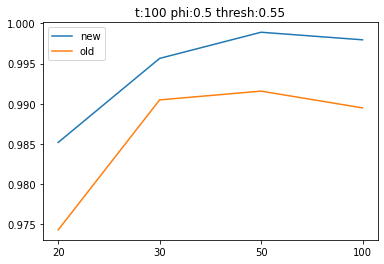

In [85]:
print(w_list)
result1 = results[:,2,3,3,0,7]
result2 = results[:,2,3,3,1,7]
plt.plot(result1)
plt.plot(result2)
plt.title('t:'+str(t_list[aa])+
          ' phi:'+str(phi_list[2])+
          ' thresh:'+str(thresh_list[3]))

plt.legend(['new','old'])
plt.xticks(list(range(len(result1))),window_size_list)
plt.show()

**********
window_size: 50
t: 30
phi: 25
thresh: 0.5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
2

1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049


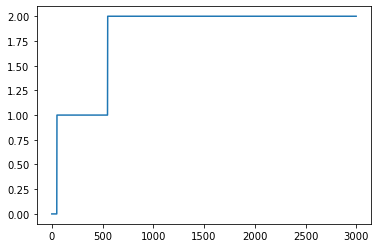

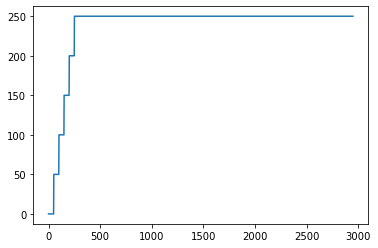

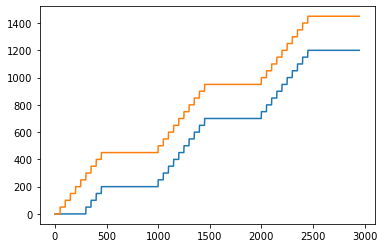

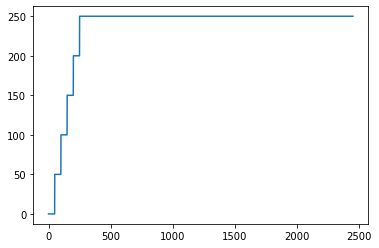

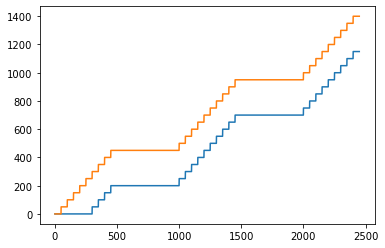

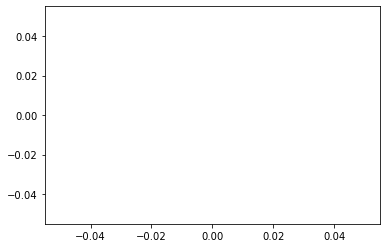

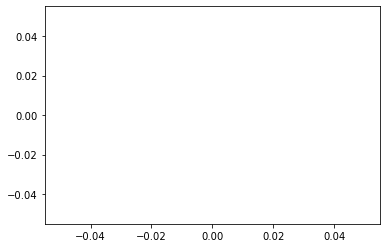

TP: 2582 TN: 200 FP: 7 FN: 161
ACC: 0.9430508474576271 Precision: 0.9972962533796833 Recall: 0.9413051403572731 F1: 0.9684921230307577
FPR: 0.033816425120772944 TPR: 0.9413051403572731


In [105]:
window_size_list = list(range(10,1000,50))
t_list = list(range(10,100,20))
phi_list = list(range(int(window_size/10),window_size,int(window_size/10)))
thresh_list = [0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75]

window_size_list = [50]
t_list = [30]
phi_list = [0.5]
thresh_list = [0.5]

results = np.zeros((len(window_size_list),len(t_list),len(phi_list),len(thresh_list),10))

for aa in range(len(window_size_list)):
    window_size = window_size_list[aa]
    for bb in range(len(t_list)):
        t = t_list[bb]
        for cc in range(len(phi_list)):
            phi = int(phi_list[cc]*window_size)
            for dd in range(len(thresh_list)):
                thresh = thresh_list[dd]

                madwin_len = [[],[],[]]

                max_i = [[],[],[]]
                min_i = [[],[],[]]
                
                print('*'*10)
                print('window_size:',window_size)
                print('t:',t)
                print('phi:',phi)
                print('thresh:',thresh)
                detector = algorithm(e=10,
                                     window_size=window_size,
                                     t=t,
                                     phi=phi,
                                     delta=0.02,
                                     min_win_size=5,
                                     thresh=thresh)
                prediction = []
                scores = []
                e_num = []
                for i in range(len(stream)):
                    x = stream[i]
                    output,var = detector.predict(x)
                    prediction += output
                    e_num.append(len(detector.ensemble))
                    print(i)
                    for e in range(len(detector.ensemble)):
                        madwin_len[e].append(len(detector.ensemble[e].madwin.W))
                        max_i[e].append(detector.ensemble[e].madwin.max_i)
                        min_i[e].append(detector.ensemble[e].madwin.min_i)
#                 print(results[aa,bb,cc,dd])
                plt.figure()
                plt.plot(e_num)
                plt.show()
                for i in range(len(madwin_len)):
                    plt.figure()
                    plt.plot(madwin_len[i])
                    plt.show()
                    plt.figure()
                    plt.plot(min_i[i])
                    plt.plot(max_i[i])
                    plt.show()
                    
                
                res = evaluation(prediction,label[:len(prediction)])
                results[aa,bb,cc,dd] = res
#                 print(results[aa,bb,cc,dd])

In [83]:
evaluation(prediction,label[:len(prediction)])

TP: 1082 TN: 23 FP: 29 FN: 666
ACC: 0.6138888888888889 Precision: 0.9738973897389739 Recall: 0.6189931350114416 F1: 0.7569080097936342
FPR: 0.5660377358490566 TPR: 0.6192109777015438


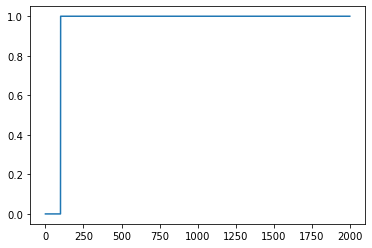

In [75]:
plt.figure()
plt.plot(e)
plt.show()

500 0
500 1
500 1
1500 1


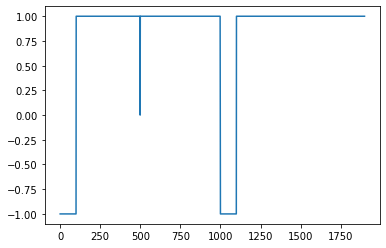

In [178]:
print('500',prediction[499])
print('500',prediction[500])
print('500',prediction[502])
print('1500',prediction[1500])
plt.figure()
plt.plot(prediction)
plt.show()

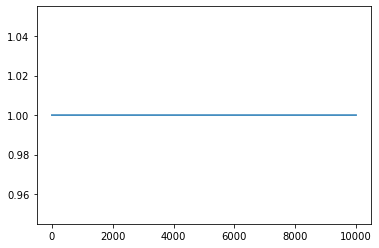

In [74]:
plt.figure()
plt.plot(label)
plt.show()

In [13]:
def stream_generator(normal,abnormal,n):
    normal_data_folder = normal
    abnormal_data_folder = abnormal
    normal_file_list = []
    abnormal_file_list = []
    for f in os.listdir(normal_data_folder):
        normal_file_list.append(normal_data_folder+f)
    for f in os.listdir(abnormal_data_folder):
        abnormal_file_list.append(abnormal_data_folder+f)
    stream_list = []
    label_list = []
    connection_list = []

    feature = ['Agent','ProcessName','TaskID','Label','Title','Host','HRT','Operation','Source','ThreadID','EventID','ProcessID']

    for i in range(n):
    
        cati = {}
        for i in range(12):
            cati[i] = []
        normal_file = random.sample(normal_file_list,1)
        abnormal_file = random.sample(abnormal_file_list,1)
#         stream_file = normal_file[1:] + abnormal_file
#         random.shuffle(stream_file)
#         stream_file = [normal_file[0]]+stream_file
        stream_file = normal_file + abnormal_file+ abnormal_file+ abnormal_file+ abnormal_file
#         print(stream_file)
        
    
        cati = {}
        for i in range(12):
            cati[feature[i]] = []
            
        stream = []
        labels = []
        connection = []
        for f in stream_file:
            if f[:len(abnormal_data_folder)]==abnormal_data_folder:
                label = 0
            else:
                label = 1
            with open(f, "r") as read_file:
                data = json.load(read_file)
            report_list = data[0]['reports']
            number_of_events = len(report_list)
            print(number_of_events)
            s = []
            l = []
            for i in range(number_of_events):
                event = [0]*12
                for j in range(12):
                    e = report_list[i].get(feature[j])
                    if e not in cati[feature[j]]:
                        cati[feature[j]].append(e)
                    event[j] = cati[feature[j]].index(e) 
                l.append(label)
                s.append(event)
#             connection.append(len(stream))
            l = np.array(l)
            s = np.array(s)
            p = np.random.permutation(len(l))
#             print(s[:10])
#             l = l[p]
#             s = s[p]
#             print(s[:10])
            if len(stream)>0:
                stream = np.concatenate((stream,s),axis=0)
                labels = np.concatenate((labels,l),axis=0)
            else:
                stream = s
                labels = l
#             print(len(l))
#             print(len(s))
#             break
#         break
#         p = np.random.permutation(len(stream))
#         stream = stream[p]
#         labels = labels[p]
        stream_list.append(stream)
        label_list.append(labels)
        connection_list.append(connection)
    
        
    return stream_list,label_list,connection_list,cati

In [14]:
def evaluation(detector,label):
    TP=0
    TN=0
    FP=0
    FN=0
    for i in range(len(label)):
        if detector.prediction[i] != -1:
            if detector.prediction[i] and label[i]:
                TP += 1
            elif detector.prediction[i] and not label[i]:
                FP += 1
            elif not detector.prediction[i] and label[i]:
                FN += 1
            else:
                TN += 1
    ACC = (TP+TN)/(TP+TN+FP+FN)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1 = 2*Precision*Recall/(Precision+Recall)
    FPR = (FP+1)/(FP+TN+1)
    TPR = (TP+1)/(TP+FN+1)
    print('TP:',TP,'TN:',TN,'FP:',FP,'FN:',FN)
    print('ACC:',ACC,'Precision:',Precision,'Recall:',Recall,'F1:',F1)
    print('FPR:',FPR,'TPR:',TPR)
    return

In [15]:
dataset = ['raw_data/shuttle.txt',
           'raw_data/smtp.txt',
           'raw_data/pima.txt',
           'raw_data/satellite.txt',
           'raw_data/smtp_http.txt',
           'raw_data/shuttle.txt',
           'raw_data/shuttle.txt']

In [70]:
a = np.loadtxt(dataset[1])
stream = a[:10000,:-1]
label = a[:10000,-1]
label = 1-label
print(stream.shape)

(10000, 3)


In [179]:
a = np.loadtxt(dataset[1])
stream = a[:,:-1]
label = a[:,-1]
label = 1-label
print(stream.shape)

(95156, 3)


In [28]:
X = stream[:100]
selector = VarianceThreshold()
Xp = selector.fit_transform(X)


In [31]:
X = []
for x in stream[:100]:
    X.append(x)
selector = VarianceThreshold()
Xp = selector.fit_transform(X)
print(Xp.shape)

(100, 8)


In [17]:
a = np.loadtxt(dataset[2])
stream = a[:,:-1]
label = a[:,-1]
label = 1-label

In [18]:
print(stream.shape)
print(label.shape)

(768, 8)
(768,)


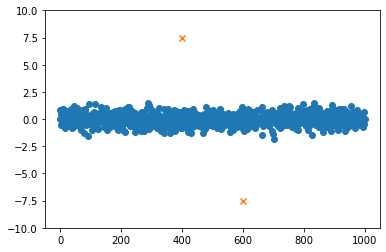

In [13]:
mean = [0,10,40,30]
var = [.5,.5,.5,.5]
X = np.array([])
for i in range(1):
    X = np.concatenate((X,np.random.normal(mean[i],var[i],1000)),axis=0)
    
plt.figure()
plt.scatter(range(len(X)),X)
plt.scatter([400,600],[7.5,-7.5],marker='x')
plt.ylim(-10,10)
plt.show()

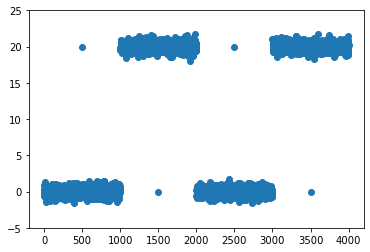

(4000, 1)


In [98]:
mean = [0,20,0,20]
var = [.5,.5,.5,.5]
X = np.array([])
for i in range(4):
    X = np.concatenate((X,np.random.normal(mean[i],var[i],1000)),axis=0)

X[500]=20
X[1500]=0
X[2500]=20
X[3500]=0
    
plt.figure()
plt.scatter(range(len(X)),X)
plt.ylim(-5,25)
plt.show()
stream = X.reshape((-1,1))
print(stream.shape)

(100,)


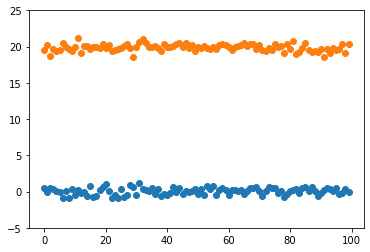

(200,)


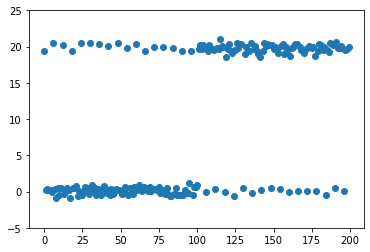

In [17]:
mean = [0,20,0,20]
var = [.5,.5,.5,.5]
X1 = np.array([])
X2 = np.array([])
X1 = np.concatenate((X1,np.random.normal(mean[0],var[0],100)),axis=0)
X2 = np.concatenate((X2,np.random.normal(mean[1],var[1],100)),axis=0)
X3,l = random_mix(X1,X2,100,(5,1))
X4,l = random_mix(X2,X1,100,(5,1))

print(X3.shape)
plt.figure()
plt.scatter(range(len(X1)),X1)
plt.scatter(range(len(X2)),X2)
plt.ylim(-5,25)
plt.show()

stream = np.concatenate((X3,X4),axis=0)
print(stream.shape)
plt.figure()
plt.scatter(range(len(stream)),stream)
plt.ylim(-5,25)
plt.show()

In [8]:
def random_mix(a,b,l,p):
    '''
    a: first stream
    b: second stream
    l: length of output stream
    p: mix persantage of two stream
    
    output:
    stream: mix stream
    label: label of mix stream
    '''
    pa,pb = p
    na = int(pa/(pa+pb)*l)
    nb = int(pb/(pa+pb)*l)
    sa = random.choices(a,k=na+1)
    sb = random.choices(b,k=nb+1)
#     print('na,nb',na,nb)
    stream = []
    label = []
    ai = 0
    bi = 0
    for i in range(l):
#         print(i,ai,bi)
        event = None
        if i%(pa+pb) == 0:
            stream.append(sb[bi])
            label.append(0)
            bi += 1
        else:
            stream.append(sa[ai])
            label.append(1)
            ai += 1
    return np.array(stream),np.array(label)

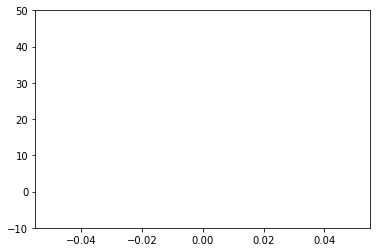

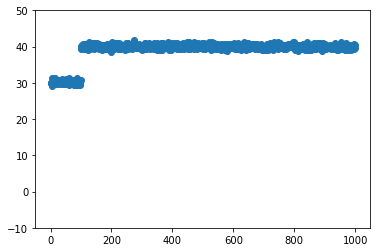

In [132]:
mean = [0,20,40,30]
var = [.5,.5,.5,.5]
normal = np.array([])
abnormal = np.array([])
# for i in range(1):
normal1 = np.concatenate((normal,np.random.normal(mean[0],var[0],1000)),axis=0)
normal2 = np.concatenate((normal,np.random.normal(mean[1],var[1],1000)),axis=0)
abnormal = np.concatenate((abnormal,np.random.normal(mean[2],var[2],1000)),axis=0)
abnormal[:100] = np.random.normal(mean[3],var[3],100)
plt.figure()
plt.scatter(range(len(normal)),normal)
plt.ylim(-10,50)
plt.show()
plt.figure()
plt.scatter(range(len(abnormal)),abnormal)
plt.ylim(-10,50)
plt.show()
stream1,label1 = random_mix(normal1,abnormal,1000,(1,1))
stream2,label2 = random_mix(normal2,abnormal,1000,(1,1))
stream = np.concatenate((stream1,stream2),axis=0)
label = np.concatenate((label1,label2),axis=0)
# stream = np.concatenate((np.random.normal(mean[0],var[0],100),stream),axis=0)
# label = np.concatenate((np.ones((100,)),label),axis=0)

2000
[ True]


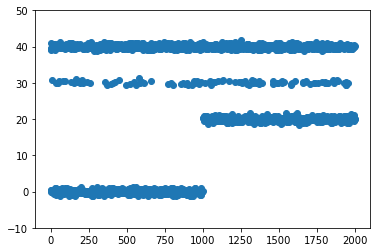

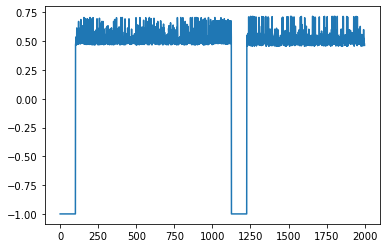

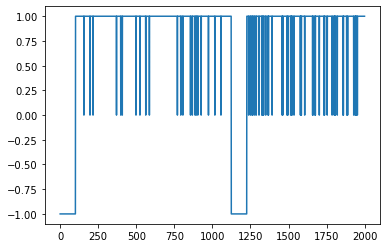

TP: 899 TN: 71 FP: 827 FN: 0
ACC: 0.5397885364496383 Precision: 0.5208574739281576 Recall: 1.0 F1: 0.684952380952381
FPR: 0.9210233592880979 TPR: 1.0


In [135]:
# X.reshape(-1,1)
stream = stream.reshape(-1,1)
detector = iForestADWIN(100,1000,50,None,thresh=0.7,text=False,delta=0.02)
print(len(stream))
for i in range(len(stream)):
    detector.add_element(stream[i])
#     if i >=200:
#         print("********",stream[i],detector.score[i])
    print(i,end='\r')
print(detector.feature_filter)
plt.figure()
plt.scatter(range(len(stream)),stream)
plt.ylim(-10,50)
plt.show()
plt.figure()
plt.plot(detector.score)
plt.show()
plt.figure()
plt.plot(detector.prediction)
# plt.plot(label_list[j])
plt.show()
evaluation(detector,label)


1000
[ True]


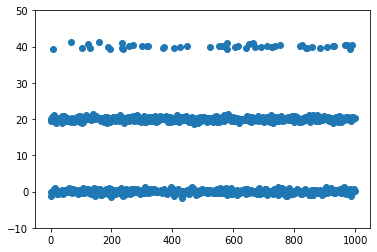

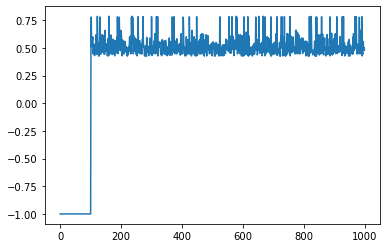

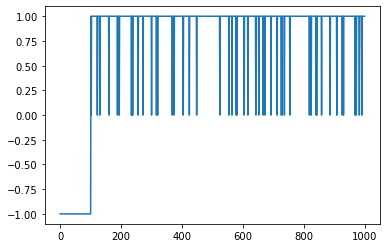

TP: 450 TN: 49 FP: 400 FN: 0
ACC: 0.5550611790878754 Precision: 0.5294117647058824 Recall: 1.0 F1: 0.6923076923076924
FPR: 0.8911111111111111 TPR: 1.0


In [114]:
# X.reshape(-1,1)
stream = stream.reshape(-1,1)
detector = iForestADWIN(100,1000,50,None,thresh=0.7,text=False,delta=0.02)
print(len(stream))
for i in range(len(stream)):
    detector.add_element(stream[i])
#     if i >=200:
#         print("********",stream[i],detector.score[i])
    print(i,end='\r')
print(detector.feature_filter)
plt.figure()
plt.scatter(range(len(stream)),stream)
plt.ylim(-10,50)
plt.show()
plt.figure()
plt.plot(detector.score)
plt.show()
plt.figure()
plt.plot(detector.prediction)
# plt.plot(label_list[j])
plt.show()
evaluation


In [88]:
def evaluation(detector,label):
    TP=0
    TN=0
    FP=0
    FN=0
    for i in range(len(label)):
        if detector.prediction[i] != -1:
            if detector.prediction[i] and label[i]:
                TP += 1
            elif detector.prediction[i] and not label[i]:
                FP += 1
            elif not detector.prediction[i] and label[i]:
                FN += 1
            else:
                TN += 1
    ACC = (TP+TN)/(TP+TN+FP+FN)
    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)
    F1 = 2*Precision*Recall/(Precision+Recall)
    FPR = (FP+1)/(FP+TN+1)
    TPR = (TP+1)/(TP+FN+1)
    print('TP:',TP,'TN:',TN,'FP:',FP,'FN:',FN)
    print('ACC:',ACC,'Precision:',Precision,'Recall:',Recall,'F1:',F1)
    print('FPR:',FPR,'TPR:',TPR)
    return

In [ ]:


# X.reshape(-1,1)
stream = X.reshape(-1,1)
for i in range(100):
    for j in range(i+1):
        detector = iForestADWIN(i,1000,j,None,thresh=0.7,text=False,delta=0.02)
        print(len(stream))
        for i in range(len(stream)):
            detector.add_element(stream[i])
        #     if i >=200:
        #         print("********",stream[i],detector.score[i])
            print(i,end='\r')
        print(detector.feature_filter)
        plt.figure()
        plt.scatter(range(len(X)),X)
        plt.ylim(-10,50)
        plt.show()
        plt.figure()
        plt.plot(detector.score)
        plt.show()
        plt.figure()
        plt.plot(detector.prediction)
        # plt.plot(label_list[j])
        plt.show()
        print(detector.score[206],detector.score[202],detector.score[800])
        print(detector.prediction[206],detector.prediction[202],detector.prediction[800])